In [8]:
import os
from pathlib import Path
import numpy as np
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import LLMChain
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI 
from langchain.llms import OpenAI 
from langchain.indexes import GraphIndexCreator 
from langchain.chains import GraphQAChain 
from langchain.document_loaders import TextLoader
from langchain.graphs.networkx_graph import NetworkxEntityGraph, parse_triples 
from langchain.prompts.prompt import PromptTemplate


from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
DATA_PATH = Path("data")

In [3]:
loader = PyPDFLoader(str(DATA_PATH /"vitamindeficiencies.pdf"))
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 3000,
    chunk_overlap  = 200,
    length_function = len,
    is_separator_regex = False,
)
texts = text_splitter.split_documents(documents)

In [7]:
db = Chroma.from_documents(texts, OpenAIEmbeddings())
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 2})

AttributeError: module 'openai' has no attribute 'error'

In [5]:
def generate_human_message(query, contexts):
    prompt = "Contexts:\n"
    for idx, context in enumerate(contexts):
        prompt += f"{idx+1}: {context.page_content}"
        prompt += "\n\n"
    prompt += f"Question: {query}"
    return prompt

In [6]:
query = "What are the symptoms and cures of Vitamin B12 deficiency?"
contexts = retriever.get_relevant_documents(query)

In [7]:
human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant. Provide an in-detailed answer to the users' question using the provided contexts."),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({}) 

'Vitamin B12 deficiency can present with various symptoms, including fatigue, weakness, constipation, loss of appetite, weight loss, numbness and tingling in the hands and feet, difficulty maintaining balance, confusion, memory problems, and soreness of the mouth or tongue. In severe cases, it can lead to neurological issues and megaloblastic anemia.\n\nTreatment for vitamin B12 deficiency typically involves supplementation with vitamin B12 either through injections or oral supplements. In cases of malabsorption, high-dose oral supplements or injections are often necessary. Identifying and addressing the underlying cause of the deficiency is crucial for effective treatment. For individuals with certain conditions like pernicious anemia, lifelong vitamin B12 supplementation may be required.\n\nIt is important to consult a healthcare provider for proper diagnosis and treatment of vitamin B12 deficiency to prevent complications and improve overall health and well-being.'

In [8]:
contexts

[Document(page_content='infants or children without any predisposing factors. In \nearly stages, cobalamin deficiency is secondary to the \nmaternal deficiency among breast-feeding mothers fol-\nlowing strict or moderate vegan diets. The main causes \nof vitamin B12 deficiency mostly are inadequate intake, \ninborn errors of metabolism or transport, and malabsorp-\ntion. Elder individuals, people with psychiatric illnesses,', metadata={'page': 2, 'source': 'data\\vitamindeficiencies.pdf'}),
 Document(page_content='doi.org/10.1007/s40519-021-01331-0\n[10] Drake V , Frei B. Micronutrient inadequacies in the US \npopulation: An overview. Oregon State University, 2017. https://\nlpi.oregonstate.edu/mic/micronutrient-inadequacies/overview. \nAccessed June 26, 2022.\n[11] Ward E. Addressing nutritional gaps with multivitamin \nand mineral supplements. Nutr J 2014;13:1-10. https://doi.\norg/10.1186/1475-2891-13-72\n[12] Bhaskaram P. Immunobiology of mild micronutrient', metadata={'page': 6, '

In [9]:
# index_creator = GraphIndexCreator(llm=OpenAI(temperature = 0))
# text = "\n\n".join([contexts[i].page_content for i in range(len(contexts))])
# graph = index_creator.from_text(text) 
# triples = graph.get_triples()

In [10]:
# "EXAMPLE\n"
# "Conversation history:\n"
# "Person #1: Did you hear aliens landed in Area 51?\n"
# "AI: No, I didn't hear that. What do you know about Area 51?\n"
# "Person #1: It's a secret military base in Nevada.\n"
# "AI: What do you know about Nevada?\n"
# "Last line of conversation:\n"
# "Person #1: It's a state in the US. It's also the number 1 producer of gold in the US.\n\n"
# f"Output: (Nevada, is a, state){KG_TRIPLE_DELIMITER}(Nevada, is in, US)"
# f"{KG_TRIPLE_DELIMITER}(Nevada, is the number 1 producer of, gold)\n"
# "END OF EXAMPLE\n\n"

In [11]:
KG_TRIPLE_DELIMITER = "<|>"
_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE = (
    "You are a networked intelligence helping a human track knowledge triples"
    " about all symptoms, treatment of Vitamin B12 deficiency and integrating"
    " them with your knowledge stored within your weights"
    " as well as that stored in a knowledge graph."
    " Extract all of the knowledge triples about."
    " A knowledge triple is a clause that contains a subject, a predicate,"
    " and an object. The subject is the entity being described,"
    " the predicate is the property of the subject that is being"
    " described, and the object is the value of the property.\n\n"  
    "EXAMPLE\n" 
    "context:\n" 
    "Vitamin B12 deficiency can occur due to various reasons including inadequate intake, inborn errors of metabolism or transport, and malabsorption. Strict or moderate vegans who do not consume animal products are at a higher risk of developing this deficiency as vitamin B12 is primarily found in animal-based foods. Other individuals who may be at risk include those with gastrointestinal disorders that affect nutrient absorption, individuals who have undergone gastrointestinal surgery, and those with certain genetic conditions.\n\nThe symptoms of vitamin B12 deficiency can vary and may include fatigue, weakness, shortness of breath, pale skin, heart palpitations, and a sore or swollen tongue. Other symptoms can include neurological problems like tingling or numbness in the hands and feet, difficulty walking, balance problems, memory loss, and mood changes.\n\nTo diagnose a vitamin B12 deficiency, a blood test can be conducted to measure the levels of vitamin B12 in the body. If a deficiency is confirmed, the treatment typically involves vitamin B12 supplementation. This can be done through oral supplements, intramuscular injections, or nasal sprays, depending on the severity of the deficiency and individual needs.\n\nFor individuals with malabsorption issues, high-dose vitamin B12 supplements may be required. In cases where the deficiency is caused by an underlying condition, such as pernicious anemia, treatment of the underlying condition may be necessary alongside vitamin B12 supplementation.\n\nIt's important to note that if the deficiency is not addressed promptly, it can lead to complications such as anemia, nerve damage, and potential long-term neurological problems. Therefore, it is advisable to consult with a healthcare professional if you suspect a vitamin B12 deficiency or experience any related symptoms. They can provide a proper diagnosis and recommend an appropriate treatment plan tailored to your specific needs."
  # #"Output:(Vitamin B12 deficiency, symptoms, fatigue){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, weakness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, pale skin){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, shortness of breath){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, dizziness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, tingling or numbness in the hands and feet){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, difficulty walking){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, mood changes){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, memory problems){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, poor concentration){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, megaloblastic anemia){KG_TRIPLE_DELIMITER}(megaloblastic anemia, symptoms, characterized by the production of large, immature red blood cells){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, addressing the underlying cause){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, replenishing the body's stores of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, increasing dietary sources of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, good food sources include meat, fish, dairy products, and fortified cereals){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, oral Vitamin B12 supplements){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, Vitamin B12 injections){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, consult with a healthcare professional){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, accurate diagnosis and appropriate treatment plan){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, determine the cause of the deficiency){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, recommend the most suitable course of action){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, regular monitoring of Vitamin B12 levels){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, ensure the deficiency is adequately managed)"
   # f"Output:(fatigue, is a, symptom){KG_TRIPLE_DELIMITER}(fatigue, caused due to, Vitamin B12 deficiency)"   
    f"Output: (Vitamin B12 deficiency, caused by, inadequate intake){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, caused by, inborn errors of metabolism or transport)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, caused by, malabsorption){KG_TRIPLE_DELIMITER}(Vegans, higher risk of, Vitamin B12 deficiency)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12, found in, animal-based foods){KG_TRIPLE_DELIMITER}(Individuals with gastrointestinal disorders, are at risk of, Vitamin B12 deficiency)"
    f"{KG_TRIPLE_DELIMITER}(Individuals who have undergone gastrointestinal surgery, may be at risk of, Vitamin B12 deficiency){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include fatigue)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include weakness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include shortness of breath)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include pale skin){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include heart palpitations)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include sore or swollen tongue){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include tingling or numbness in hands and feet)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include difficulty walking){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include balance problems)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include memory loss){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include mood changes)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, diagnosed by, blood test){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, involves supplementation)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, oral supplements){KG_TRIPLE_DELIMITER}(Vitamin B12 supplements, can be administered through, intramuscular injections)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 supplements, can be administered through, nasal sprays){KG_TRIPLE_DELIMITER}(High-dose vitamin B12 supplements, are required for, individuals with malabsorption issues)"
    f"{KG_TRIPLE_DELIMITER}(Pernicious anemia, requires treatment of, underlying condition along with B12 supplementation)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to anemia){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to nerve damage){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to long-term neurological problems)"
f"{KG_TRIPLE_DELIMITER}(Healthcare professional, can provide, diagnosis and treatment plan for Vitamin B12 deficiency)\n"
    "END OF EXAMPLE\n\n"
    "Context (for reference only):\n"
    "{context}"
    "\nLast line of context (for extraction):\n"
    "Output:"
)

KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT = PromptTemplate(
    input_variables=["context"],
    template=_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE,
)

In [12]:
prompt = KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT

In [13]:
graph = NetworkxEntityGraph() 
llm = OpenAI(model_name = "gpt-4") 
chain = LLMChain(llm=llm, prompt=prompt) 
result = chain.invoke({"context": text})
output = chain.result()  
knowledge = parse_triples(output)
for triple in knowledge:
    graph.add_triple(triple) 

C:\Users\saikeerthana\.conda\envs\rag\lib\site-packages\langchain\llms\openai.py:202: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
C:\Users\saikeerthana\.conda\envs\rag\lib\site-packages\langchain\llms\openai.py:790: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


NameError: name 'text' is not defined

In [14]:
query = "what are the different types of deficiencies mentioned in the text file?"
contexts = retriever.get_relevant_documents(query)

human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant. Provide a succint answer to the users' question using the provided contexts."),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({})

'The text file mentions micronutrient deficiencies as the most prevalent type of nutritional deficiencies, caused by insufficient intake of essential micronutrients such as iron, iodine, calcium, zinc, magnesium, fluoride, and vitamins A, B6, B12, C, D, E, and K.'

In [15]:
human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant. Provide an in-detailed answer to the users' question using the provided contexts."),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({}) 

'The text file mentions various types of deficiencies, including macro- and micronutrient deficiencies. Micronutrient deficiencies are highlighted as the most prevalent type of nutritional deficiencies. Some essential micronutrients mentioned in the text that are crucial for maintaining optimal health include iron, iodine, calcium, zinc, magnesium, fluoride, and vitamins A, B6, B12, C, D, E, and K. These deficiencies can lead to serious diseases such as goiter, mental retardation, acute respiratory infections, decreased cognitive function, cancer, vision loss, rickets, and pellagra. Additionally, the text discusses specific deficiencies in the US population, such as inadequate intake of vitamins D, E, A, C, magnesium, calcium, potassium, and vitamin K, based on NHANES data.'

In [16]:
query = "Can you give me all the information available about symptoms, causes, and cures of Vitamin B12 deficiency?"
contexts = retriever.get_relevant_documents(query)

human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ( "You are a networked intelligence helping a human track knowledge triples"
    " about all symptoms, treatment of Vitamin B12 deficiency and integrating"
    " them with your knowledge stored within your weights"
    " as well as that stored in a knowledge graph."
    " Extract all of the knowledge triples from the last line of conversation."
    " A knowledge triple is a clause that contains a subject, a predicate,"
    " and an object. The subject is the entity being described,"
    " the predicate is the property of the subject that is being"
    " described, and the object is the value of the property.\n\n"  
    "EXAMPLE\n" 
    "context:\n" 
    "Vitamin B12 deficiency can occur due to various reasons including inadequate intake, inborn errors of metabolism or transport, and malabsorption. Strict or moderate vegans who do not consume animal products are at a higher risk of developing this deficiency as vitamin B12 is primarily found in animal-based foods. Other individuals who may be at risk include those with gastrointestinal disorders that affect nutrient absorption, individuals who have undergone gastrointestinal surgery, and those with certain genetic conditions.\n\nThe symptoms of vitamin B12 deficiency can vary and may include fatigue, weakness, shortness of breath, pale skin, heart palpitations, and a sore or swollen tongue. Other symptoms can include neurological problems like tingling or numbness in the hands and feet, difficulty walking, balance problems, memory loss, and mood changes.\n\nTo diagnose a vitamin B12 deficiency, a blood test can be conducted to measure the levels of vitamin B12 in the body. If a deficiency is confirmed, the treatment typically involves vitamin B12 supplementation. This can be done through oral supplements, intramuscular injections, or nasal sprays, depending on the severity of the deficiency and individual needs.\n\nFor individuals with malabsorption issues, high-dose vitamin B12 supplements may be required. In cases where the deficiency is caused by an underlying condition, such as pernicious anemia, treatment of the underlying condition may be necessary alongside vitamin B12 supplementation.\n\nIt's important to note that if the deficiency is not addressed promptly, it can lead to complications such as anemia, nerve damage, and potential long-term neurological problems. Therefore, it is advisable to consult with a healthcare professional if you suspect a vitamin B12 deficiency or experience any related symptoms. They can provide a proper diagnosis and recommend an appropriate treatment plan tailored to your specific needs."
   f"Output:(Vitamin B12 deficiency, symptoms, fatigue){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, weakness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, pale skin){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, shortness of breath){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, dizziness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, tingling or numbness in the hands and feet){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, difficulty walking){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, mood changes){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, memory problems){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, poor concentration){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, megaloblastic anemia){KG_TRIPLE_DELIMITER}(megaloblastic anemia, symptoms, characterized by the production of large, immature red blood cells){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, addressing the underlying cause){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, replenishing the body's stores of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, increasing dietary sources of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, good food sources include meat, fish, dairy products, and fortified cereals){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, oral Vitamin B12 supplements){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, Vitamin B12 injections){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, consult with a healthcare professional){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, accurate diagnosis and appropriate treatment plan){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, determine the cause of the deficiency){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, recommend the most suitable course of action){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, regular monitoring of Vitamin B12 levels){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, ensure the deficiency is adequately managed)"
   # f"Output:(fatigue, is a, symptom){KG_TRIPLE_DELIMITER}(fatigue, caused due to, Vitamin B12 deficiency)"  
    "END OF EXAMPLE\n\n"
   # "EXAMPLE\n" 
   # "context:\n" 
   # "Vitamin B12 deficiency can occur due to various reasons including inadequate intake, inborn errors of metabolism or transport, and malabsorption. Strict or moderate vegans who do not consume animal products are at a higher risk of developing this deficiency as vitamin B12 is primarily found in animal-based foods. Other individuals who may be at risk include those with gastrointestinal disorders that affect nutrient absorption, individuals who have undergone gastrointestinal surgery, and those with certain genetic conditions.\n\nThe symptoms of vitamin B12 deficiency can vary and may include fatigue, weakness, shortness of breath, pale skin, heart palpitations, and a sore or swollen tongue. Other symptoms can include neurological problems like tingling or numbness in the hands and feet, difficulty walking, balance problems, memory loss, and mood changes.\n\nTo diagnose a vitamin B12 deficiency, a blood test can be conducted to measure the levels of vitamin B12 in the body. If a deficiency is confirmed, the treatment typically involves vitamin B12 supplementation. This can be done through oral supplements, intramuscular injections, or nasal sprays, depending on the severity of the deficiency and individual needs.\n\nFor individuals with malabsorption issues, high-dose vitamin B12 supplements may be required. In cases where the deficiency is caused by an underlying condition, such as pernicious anemia, treatment of the underlying condition may be necessary alongside vitamin B12 supplementation.\n\nIt's important to note that if the deficiency is not addressed promptly, it can lead to complications such as anemia, nerve damage, and potential long-term neurological problems. Therefore, it is advisable to consult with a healthcare professional if you suspect a vitamin B12 deficiency or experience any related symptoms. They can provide a proper diagnosis and recommend an appropriate treatment plan tailored to your specific needs."
  #  f"Output: (increasing dietary sources, is the, treatment){KG_TRIPLE_DELIMITER}(increasing dietary sources, cures, Vitamin B12 deficiency)" 
    "END OF EXAMPLE\n\n"),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({})  

'(Symptoms, cobalamin deficiency, secondary to maternal deficiency)<|>(Symptoms, cobalamin deficiency, breast-feeding mothers)<|>(Symptoms, cobalamin deficiency, vegan diets)<|>(Causes, vitamin B12 deficiency, inadequate intake)<|>(Causes, vitamin B12 deficiency, inborn errors of metabolism)<|>(Causes, vitamin B12 deficiency, malabsorption)<|>(Causes, vitamin B12 deficiency, elderly individuals)<|>(Causes, vitamin B12 deficiency, psychiatric illnesses)<|>(Cures, vitamin B12 deficiency, oral supplements)<|>(Cures, vitamin B12 deficiency, intramuscular injections)<|>(Cures, vitamin B12 deficiency, nasal sprays)<|>(Cures, vitamin B12 deficiency, high-dose supplements)<|>(Cures, vitamin B12 deficiency, underlying condition treatment)<|>(Cures, vitamin B12 deficiency, pernicious anemia)<|>(Cures, vitamin B12 deficiency, healthcare professional consultation)<|>(Cures, vitamin B12 deficiency, appropriate treatment plan)<|>(Cures, vitamin B12 deficiency, deficiency complications)<|>(Cures, vit

In [17]:
context_1 = '''Knowledge triples extracted:\n\n1. (Vitamin B12 deficiency, causes, inadequate intake)\n2. (Vitamin B12 deficiency, causes, inborn errors of metabolism or transport)\n3. (Vitamin B12 deficiency, causes, malabsorption)\n4. (Vitamin B12 deficiency, symptoms, fatigue)\n5. (Vitamin B12 deficiency, symptoms, weakness)\n6. (Vitamin B12 deficiency, symptoms, shortness of breath)\n7. (Vitamin B12 deficiency, symptoms, pale skin)\n8. (Vitamin B12 deficiency, symptoms, heart palpitations)\n9. (Vitamin B12 deficiency, symptoms, sore or swollen tongue)\n10. (Vitamin B12 deficiency, symptoms, tingling or numbness in the hands and feet)\n11. (Vitamin B12 deficiency, symptoms, difficulty walking)\n12. (Vitamin B12 deficiency, symptoms, balance problems)\n13. (Vitamin B12 deficiency, symptoms, memory loss)\n14. (Vitamin B12 deficiency, symptoms, mood changes)\n15. (Vitamin B12 deficiency, symptoms, anemia)\n16. (Vitamin B12 deficiency, treatment, vitamin B12 supplementation)\n17. (Vitamin B12 deficiency, treatment, oral supplements)\n18. (Vitamin B12 deficiency, treatment, intramuscular injections)\n19. (Vitamin B12 deficiency, treatment, nasal sprays)\n20. (Vitamin B12 deficiency, treatment, high-dose supplements for malabsorption issues)\n21. (Vitamin B12 deficiency, treatment, addressing the underlying cause)\n22. (Vitamin B12 deficiency, treatment, replenishing the body's stores of Vitamin B12)\n23. (Vitamin B12 deficiency, treatment, increasing dietary sources of Vitamin B12)\n24. (Vitamin B12 deficiency, treatment, good food sources include meat, fish, dairy products, and fortified cereals)\n25. (Vitamin B12 deficiency, treatment, consult with a healthcare professional)\n26. (Vitamin B12 deficiency, treatment, accurate diagnosis and appropriate treatment plan)\n27. (Vitamin B12 deficiency, treatment, determine the cause of the deficiency)\n28. (Vitamin B12 deficiency, treatment, recommend the most suitable course of action)\n29. (Vitamin B12 deficiency, treatment, regular monitoring of Vitamin B12 levels)\n30. (Vitamin B12 deficiency, treatment, ensure the deficiency is adequately managed)'''

In [18]:
index_creator = GraphIndexCreator(llm=OpenAI(temperature = 0)) 
graph = index_creator.from_text(context_1) 
triples = graph.get_triples() 
triples

InvalidRequestError: The model `text-davinci-003` has been deprecated, learn more here: https://platform.openai.com/docs/deprecations

In [17]:
from langchain.chains import GraphQAChain
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run('what are the symptoms of vitamin b12 deficiency?')



> Entering new GraphQAChain chain...
Entities Extracted:
 NONE
Full Context:


> Finished chain.


' Vitamin B12 deficiency can cause a variety of symptoms, including fatigue, weakness, constipation, loss of appetite, weight loss, and numbness or tingling in the hands and feet.'

In [18]:
graph.write_to_gml("graphnew.gml")

In [19]:
from langchain.indexes.graph import NetworkxEntityGraph
loaded_graph = NetworkxEntityGraph.from_gml("graphnew.gml") 
loaded_graph.get_triples()

[('Vitamin B12 deficiency', 'inadequate intake', 'causes'),
 ('Vitamin B12 deficiency',
  'inborn errors of metabolism or transport',
  'causes'),
 ('Vitamin B12 deficiency', 'malabsorption', 'causes'),
 ('Vitamin B12 deficiency', 'fatigue', 'symptoms'),
 ('Vitamin B12 deficiency', 'weakness', 'symptoms'),
 ('Vitamin B12 deficiency', 'shortness of breath', 'symptoms'),
 ('Vitamin B12 deficiency', 'pale skin', 'symptoms'),
 ('Vitamin B12 deficiency', 'heart palpitations', 'symptoms'),
 ('Vitamin B12 deficiency', 'sore or swollen tongue', 'symptoms'),
 ('Vitamin B12 deficiency',
  'tingling or numbness in the hands and feet',
  'symptoms'),
 ('Vitamin B12 deficiency', 'difficulty walking', 'symptoms'),
 ('Vitamin B12 deficiency', 'balance problems', 'symptoms'),
 ('Vitamin B12 deficiency', 'memory loss', 'symptoms'),
 ('Vitamin B12 deficiency', 'mood changes', 'symptoms'),
 ('Vitamin B12 deficiency', 'anemia', 'symptoms'),
 ('Vitamin B12 deficiency', 'vitamin B12 supplementation', 'treat

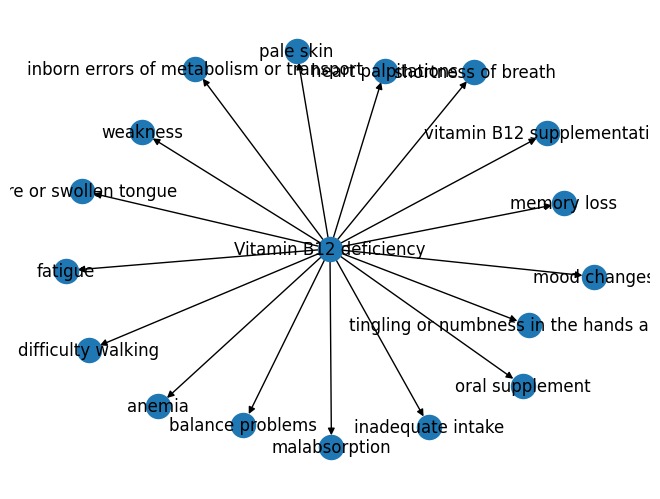

In [126]:
import networkx as nx 
import matplotlib.pyplot as plt

# Read the graph from the file
G = nx.read_gml("graphnew.gml")

# Draw the graph
nx.draw(G, with_labels=True)

# Show the graph
plt.show()

In [20]:
query = "Can you give me all the information available about symptoms, causes, and cures of Vitamin B12 deficiency?"
contexts = retriever.get_relevant_documents(query)

human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ("You are a networked intelligence helping a human track knowledge triples"
    " about all symptoms, treatment of Vitamin B12 deficiency and integrating"
    " them with your knowledge stored within your weights"
    " as well as that stored in a knowledge graph."
    " Extract all of the knowledge triples about."
    " A knowledge triple is a clause that contains a subject, a predicate,"
    " and an object. The subject is the entity being described,"
    " the predicate is the property of the subject that is being"
    " described, and the object is the value of the property.\n\n"  
    "EXAMPLE\n" 
    "context:\n" 
    "Vitamin B12 deficiency can occur due to various reasons including inadequate intake, inborn errors of metabolism or transport, and malabsorption. Strict or moderate vegans who do not consume animal products are at a higher risk of developing this deficiency as vitamin B12 is primarily found in animal-based foods. Other individuals who may be at risk include those with gastrointestinal disorders that affect nutrient absorption, individuals who have undergone gastrointestinal surgery, and those with certain genetic conditions.\n\nThe symptoms of vitamin B12 deficiency can vary and may include fatigue, weakness, shortness of breath, pale skin, heart palpitations, and a sore or swollen tongue. Other symptoms can include neurological problems like tingling or numbness in the hands and feet, difficulty walking, balance problems, memory loss, and mood changes.\n\nTo diagnose a vitamin B12 deficiency, a blood test can be conducted to measure the levels of vitamin B12 in the body. If a deficiency is confirmed, the treatment typically involves vitamin B12 supplementation. This can be done through oral supplements, intramuscular injections, or nasal sprays, depending on the severity of the deficiency and individual needs.\n\nFor individuals with malabsorption issues, high-dose vitamin B12 supplements may be required. In cases where the deficiency is caused by an underlying condition, such as pernicious anemia, treatment of the underlying condition may be necessary alongside vitamin B12 supplementation.\n\nIt's important to note that if the deficiency is not addressed promptly, it can lead to complications such as anemia, nerve damage, and potential long-term neurological problems. Therefore, it is advisable to consult with a healthcare professional if you suspect a vitamin B12 deficiency or experience any related symptoms. They can provide a proper diagnosis and recommend an appropriate treatment plan tailored to your specific needs."
  # #"Output:(Vitamin B12 deficiency, symptoms, fatigue){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, weakness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, pale skin){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, shortness of breath){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, dizziness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, tingling or numbness in the hands and feet){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, difficulty walking){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, mood changes){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, memory problems){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, poor concentration){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, megaloblastic anemia){KG_TRIPLE_DELIMITER}(megaloblastic anemia, symptoms, characterized by the production of large, immature red blood cells){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, addressing the underlying cause){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, replenishing the body's stores of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, increasing dietary sources of Vitamin B12){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, good food sources include meat, fish, dairy products, and fortified cereals){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, oral Vitamin B12 supplements){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, Vitamin B12 injections){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, consult with a healthcare professional){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, accurate diagnosis and appropriate treatment plan){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, determine the cause of the deficiency){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, recommend the most suitable course of action){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, regular monitoring of Vitamin B12 levels){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, ensure the deficiency is adequately managed)"
   # f"Output:(fatigue, is a, symptom){KG_TRIPLE_DELIMITER}(fatigue, caused due to, Vitamin B12 deficiency)"   
    f"Output: (Vitamin B12 deficiency, caused by, inadequate intake){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, caused by, inborn errors of metabolism or transport)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, caused by, malabsorption){KG_TRIPLE_DELIMITER}(Vegans, higher risk of, Vitamin B12 deficiency)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12, found in, animal-based foods){KG_TRIPLE_DELIMITER}(Individuals with gastrointestinal disorders, are at risk of, Vitamin B12 deficiency)"
    f"{KG_TRIPLE_DELIMITER}(Individuals who have undergone gastrointestinal surgery, may be at risk of, Vitamin B12 deficiency){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, may include fatigue)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include weakness){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include shortness of breath)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include pale skin){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include heart palpitations)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include sore or swollen tongue){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include tingling or numbness in hands and feet)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include difficulty walking){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include balance problems)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include memory loss){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, symptoms, include mood changes)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, diagnosed by, blood test){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, involves supplementation)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, treatment, oral supplements){KG_TRIPLE_DELIMITER}(Vitamin B12 supplements, can be administered through, intramuscular injections)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 supplements, can be administered through, nasal sprays){KG_TRIPLE_DELIMITER}(High-dose vitamin B12 supplements, are required for, individuals with malabsorption issues)"
    f"{KG_TRIPLE_DELIMITER}(Pernicious anemia, requires treatment of, underlying condition along with B12 supplementation)"
    f"{KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to anemia){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to nerve damage){KG_TRIPLE_DELIMITER}(Vitamin B12 deficiency, if not addressed, can lead to long-term neurological problems)"
f"{KG_TRIPLE_DELIMITER}(Healthcare professional, can provide, diagnosis and treatment plan for Vitamin B12 deficiency)\n"
    "END OF EXAMPLE\n\n"),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({})  

'Knowledge Triples:\n1. (Vitamin B12 deficiency, can occur due to, inadequate intake)\n2. (Vitamin B12 deficiency, can occur due to, inborn errors of metabolism or transport)\n3. (Vitamin B12 deficiency, can occur due to, malabsorption)\n4. (Breast-feeding mothers following strict or moderate vegan diets, can cause, cobalamin deficiency in infants)\n5. (Vitamin B12 deficiency, can occur in elder individuals)\n6. (Vitamin B12 deficiency, can occur in people with psychiatric illnesses)\n7. (Vegans, are at a higher risk of developing, Vitamin B12 deficiency)\n8. (Vitamin B12, is primarily found in, animal-based foods)\n9. (Individuals with gastrointestinal disorders that affect nutrient absorption, are at risk of, Vitamin B12 deficiency)\n10. (Individuals who have undergone gastrointestinal surgery, may be at risk of, Vitamin B12 deficiency)\n11. (Vitamin B12 deficiency, symptoms, may include fatigue)\n12. (Vitamin B12 deficiency, symptoms, include weakness)\n13. (Vitamin B12 deficiency, 

In [21]:
enhanced_context = '''Knowledge Triples:\n1. (Vitamin B12 deficiency, can occur due to, inadequate intake)\n2. (Vitamin B12 deficiency, can occur due to, inborn errors of metabolism or transport)\n3. (Vitamin B12 deficiency, can occur due to, malabsorption)\n4. (Breastfeeding mothers following strict or moderate vegan diets, can cause, cobalamin deficiency in infants or children)\n5. (Elder individuals, at higher risk of, Vitamin B12 deficiency)\n6. (People with psychiatric illnesses, at higher risk of, Vitamin B12 deficiency)\n7. (Vitamin B12, primarily found in, animal-based foods)\n8. (Gastrointestinal disorders, can put individuals at risk of, Vitamin B12 deficiency)\n9. (Gastrointestinal surgery, may increase the risk of, Vitamin B12 deficiency)\n10. (Vegans, at a higher risk of, Vitamin B12 deficiency)\n11. (Vitamin B12 deficiency, symptoms, may include fatigue)\n12. (Vitamin B12 deficiency, symptoms, include weakness)\n13. (Vitamin B12 deficiency, symptoms, include shortness of breath)\n14. (Vitamin B12 deficiency, symptoms, include pale skin)\n15. (Vitamin B12 deficiency, symptoms, include heart palpitations)\n16. (Vitamin B12 deficiency, symptoms, include sore or swollen tongue)\n17. (Vitamin B12 deficiency, symptoms, include tingling or numbness in hands and feet)\n18. (Vitamin B12 deficiency, symptoms, include difficulty walking)\n19. (Vitamin B12 deficiency, symptoms, include balance problems)\n20. (Vitamin B12 deficiency, symptoms, include memory loss)\n21. (Vitamin B12 deficiency, symptoms, include mood changes)\n22. (Vitamin B12 deficiency, can be diagnosed by, blood test)\n23. (Vitamin B12 deficiency, treatment, typically involves supplementation)\n24. (Vitamin B12 deficiency, treatment, can include oral supplements)\n25. (Vitamin B12 deficiency, treatment, can include intramuscular injections)\n26. (Vitamin B12 deficiency, treatment, can include nasal sprays)\n27. (Individuals with malabsorption issues, may require high-dose vitamin B12 supplements)\n28. (Pernicious anemia, requires treatment of underlying condition along with B12 supplementation)\n29. (If vitamin B12 deficiency is not addressed promptly, it can lead to anemia)\n30. (If vitamin B12 deficiency is not addressed promptly, it can lead to nerve damage)\n31. (If vitamin B12 deficiency is not addressed promptly, it can lead to long-term neurological problems)\n32. (Healthcare professional, can provide diagnosis and treatment plan for Vitamin B12 deficiency)'''

In [71]:
index_creator = GraphIndexCreator(llm=OpenAI(temperature = 0)) 
graph = index_creator.from_text(enhanced_context) 
triples = graph.get_triples() 
triples

[('Vitamin B12 deficiency', 'inadequate intake', 'can occur due to'),
 ('Vitamin B12 deficiency',
  'inborn errors of metabolism or transport',
  'can occur due to'),
 ('Vitamin B12 deficiency', 'malabsorption', 'can occur due to'),
 ('Vitamin B12 deficiency', 'may include fatigue', 'symptoms'),
 ('Vitamin B12 deficiency', 'include weakness', 'symptoms'),
 ('Vitamin B12 deficiency', 'include shortness of breath', 'symptoms'),
 ('Vitamin B12 deficiency', 'include pale skin', 'symptoms'),
 ('Breastfeeding mothers following strict or moderate vegan diets',
  'cobalamin deficiency in infants or children',
  'can cause'),
 ('Elder individuals', 'Vitamin B12 deficiency', 'at higher risk of'),
 ('People with psychiatric illnesses',
  'Vitamin B12 deficiency',
  'at higher risk of'),
 ('Vitamin B12', 'animal-based foods', 'primarily found in'),
 ('Gastrointestinal disorders',
  'Vitamin B12 deficiency',
  'can put individuals at risk of'),
 ('Gastrointestinal surgery',
  'Vitamin B12 deficienc

In [22]:
from langchain.chains import GraphQAChain
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run('what are the symptoms, causes and treatment of vitamin b12 deficiency?')



> Entering new GraphQAChain chain...
Entities Extracted:
 NONE
Full Context:


> Finished chain.


'\n\nSymptoms of vitamin B12 deficiency include fatigue, pale skin, shortness of breath, dizziness, and a sore tongue. The main cause of vitamin B12 deficiency is a lack of the vitamin in the diet, but it can also be caused by certain medical conditions or medications. Treatment for vitamin B12 deficiency usually involves taking vitamin B12 supplements and eating foods that are rich in the vitamin.'

In [23]:
graph.write_to_gml("graphnewenhanced.gml")

In [24]:
from langchain.indexes.graph import NetworkxEntityGraph
loaded_graph = NetworkxEntityGraph.from_gml("graphnewenhanced.gml") 
loaded_graph.get_triples()

[('Vitamin B12 deficiency', 'inadequate intake', 'causes'),
 ('Vitamin B12 deficiency',
  'inborn errors of metabolism or transport',
  'causes'),
 ('Vitamin B12 deficiency', 'malabsorption', 'causes'),
 ('Vitamin B12 deficiency', 'fatigue', 'symptoms'),
 ('Vitamin B12 deficiency', 'weakness', 'symptoms'),
 ('Vitamin B12 deficiency', 'shortness of breath', 'symptoms'),
 ('Vitamin B12 deficiency', 'pale skin', 'symptoms'),
 ('Vitamin B12 deficiency', 'heart palpitations', 'symptoms'),
 ('Vitamin B12 deficiency', 'sore or swollen tongue', 'symptoms'),
 ('Vitamin B12 deficiency',
  'tingling or numbness in the hands and feet',
  'symptoms'),
 ('Vitamin B12 deficiency', 'difficulty walking', 'symptoms'),
 ('Vitamin B12 deficiency', 'balance problems', 'symptoms'),
 ('Vitamin B12 deficiency', 'memory loss', 'symptoms'),
 ('Vitamin B12 deficiency', 'mood changes', 'symptoms'),
 ('Vitamin B12 deficiency', 'anemia', 'symptoms'),
 ('Vitamin B12 deficiency', 'vitamin B12 supplementation', 'treat

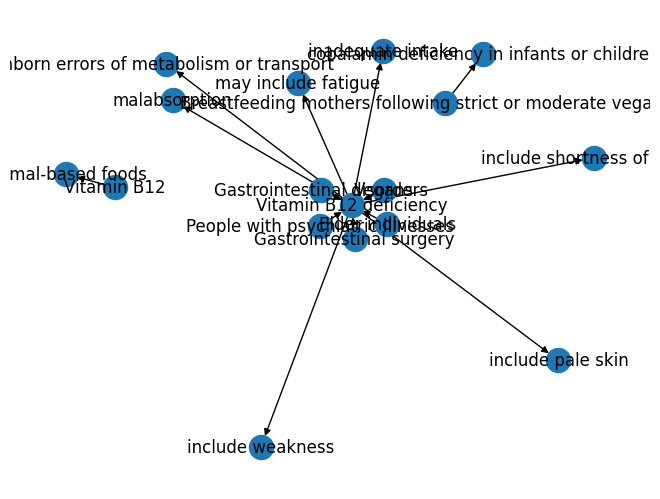

In [75]:
import networkx as nx 
import matplotlib.pyplot as plt

# Read the graph from the file
G = nx.read_gml("graphnewenhanced.gml")

# Draw the graph
nx.draw(G, with_labels=True)

# Show the graph
plt.show()

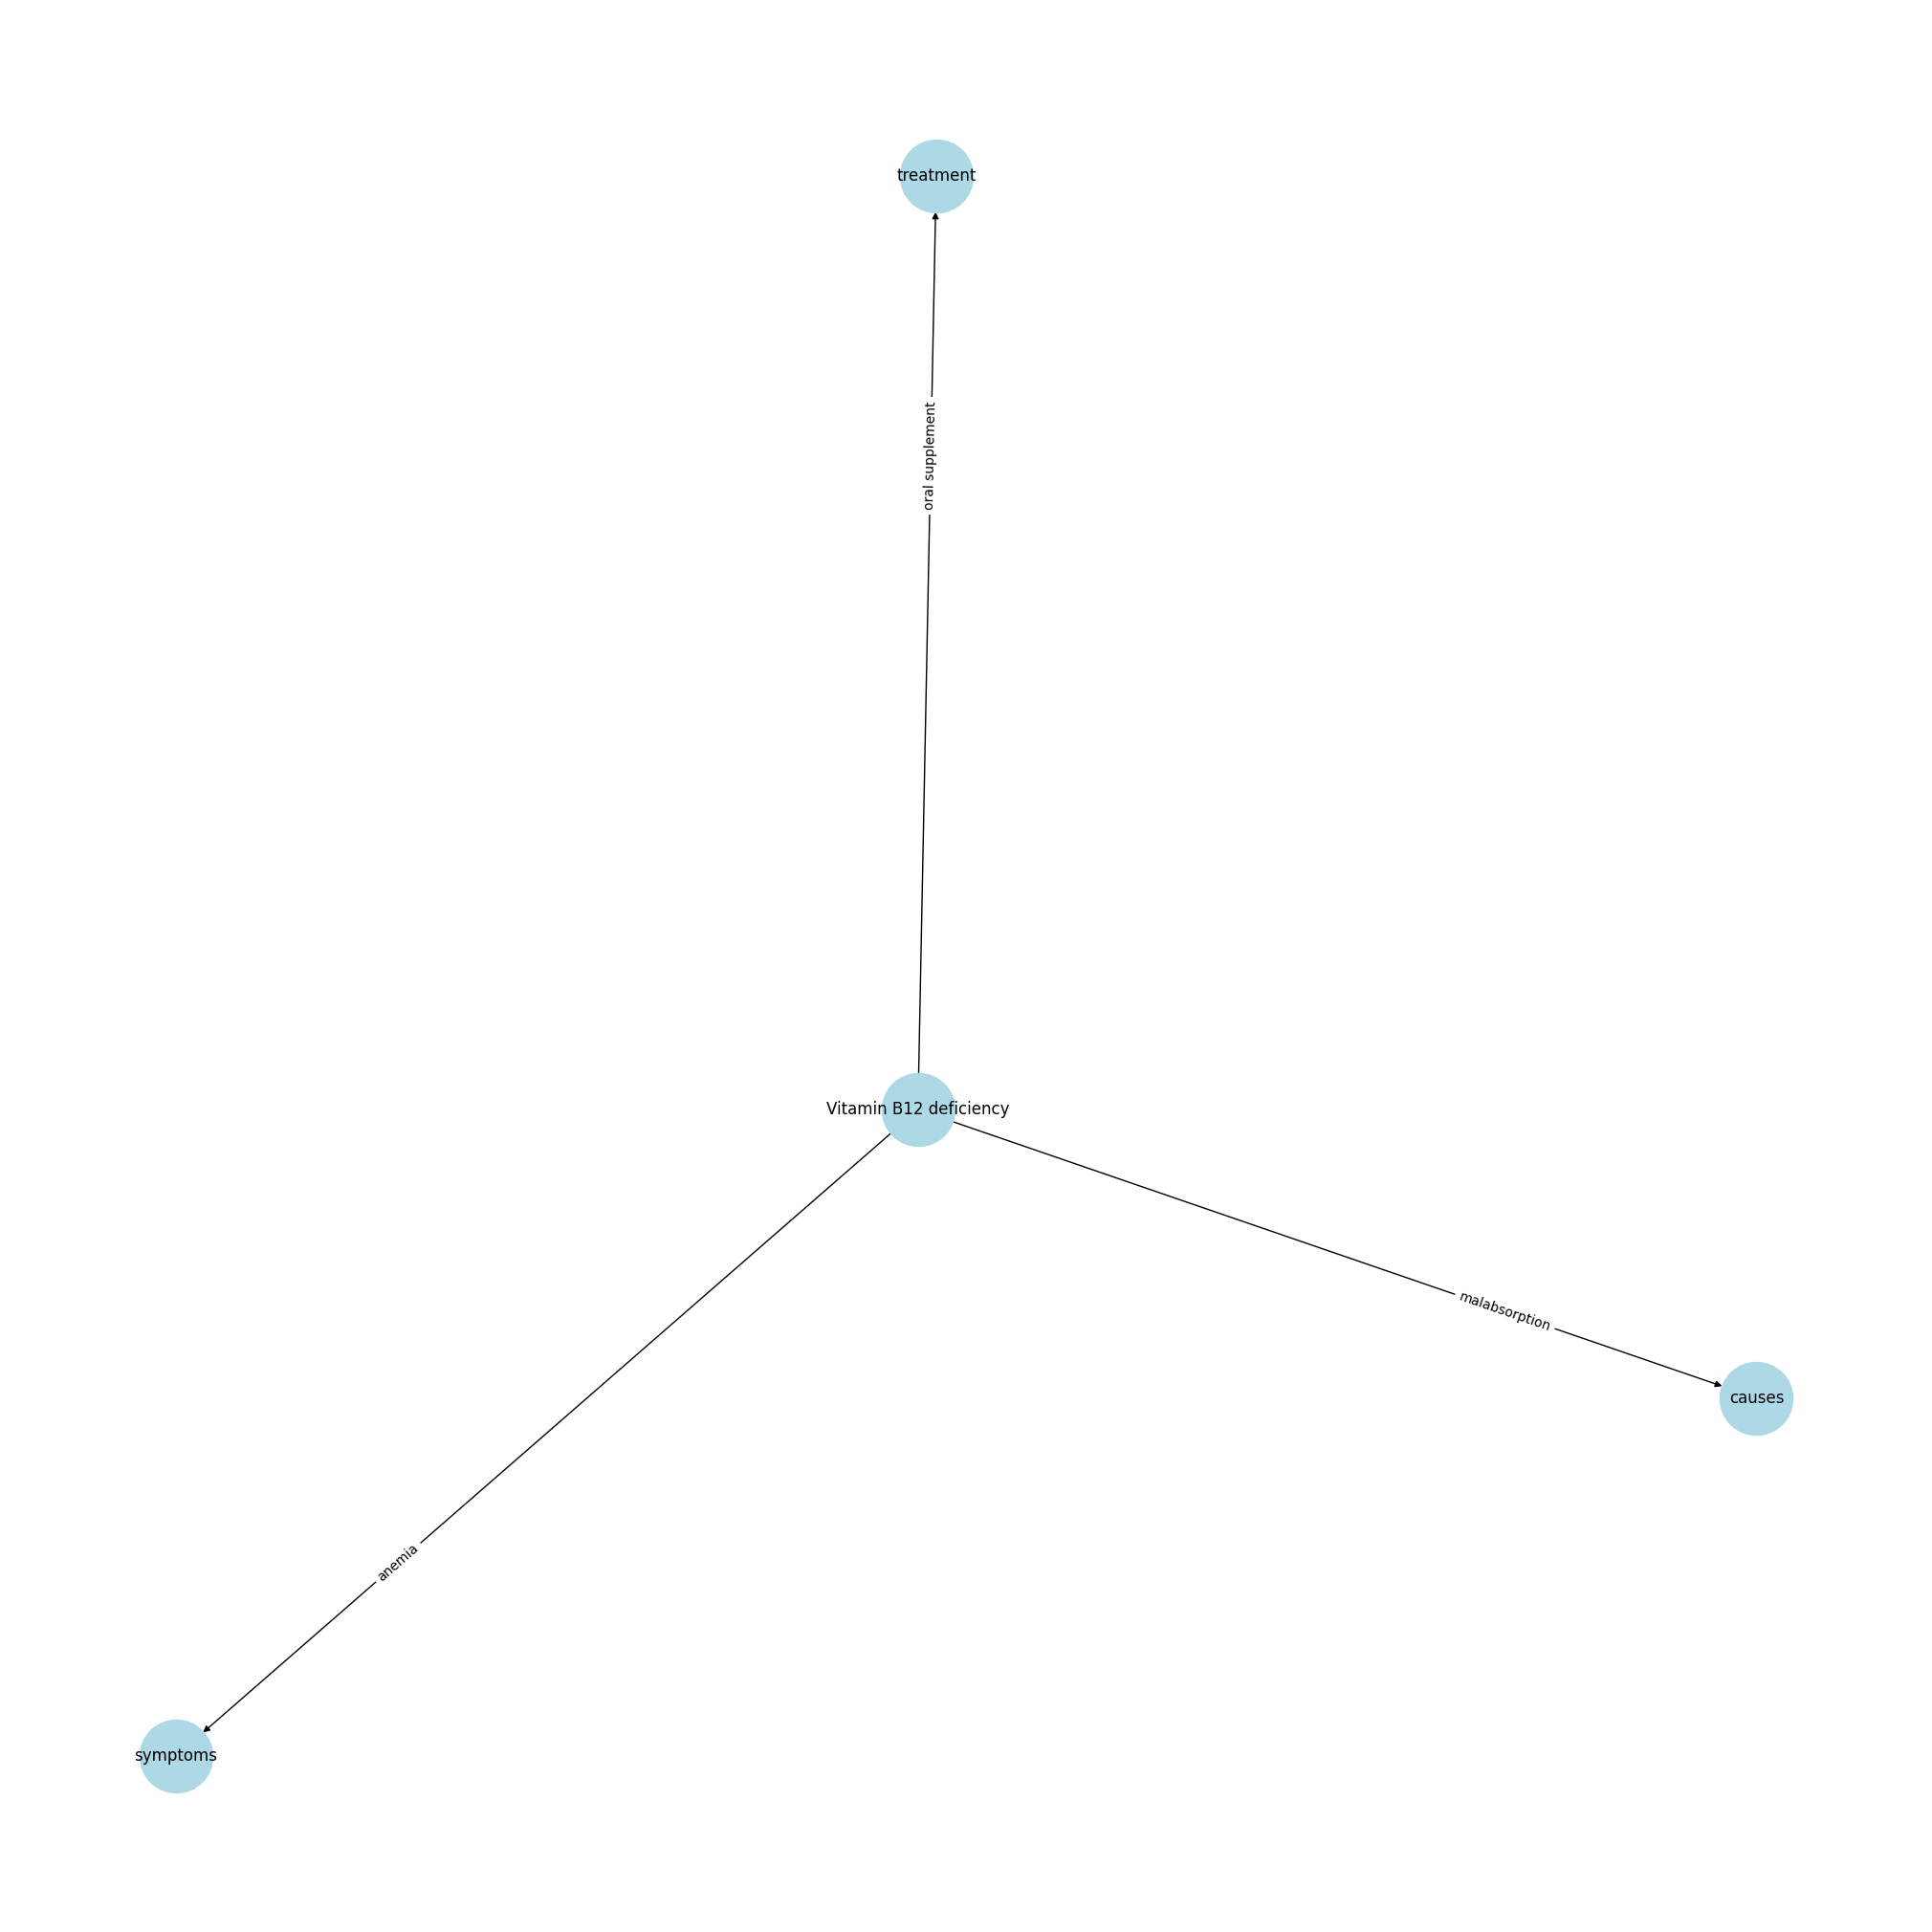

In [25]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for (subject, predicate, obj) in triples:
    G.add_edge(subject, obj, label=predicate)

# Use a layout that spaces out the nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust 'k' for spacing and 'iterations' for refinement

# Draw the graph with nodes and labels using a larger figure size
plt.figure(figsize=(20, 20))  # Increase figure size
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12)

# Draw edge labels, adjusting label position to avoid overlap
edge_labels = dict([((u, v,), d['label']) for u, v, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=10)

# Show the graph
plt.axis('off')  # Turn off the axis
plt.show()

In [26]:
! pip install scipy

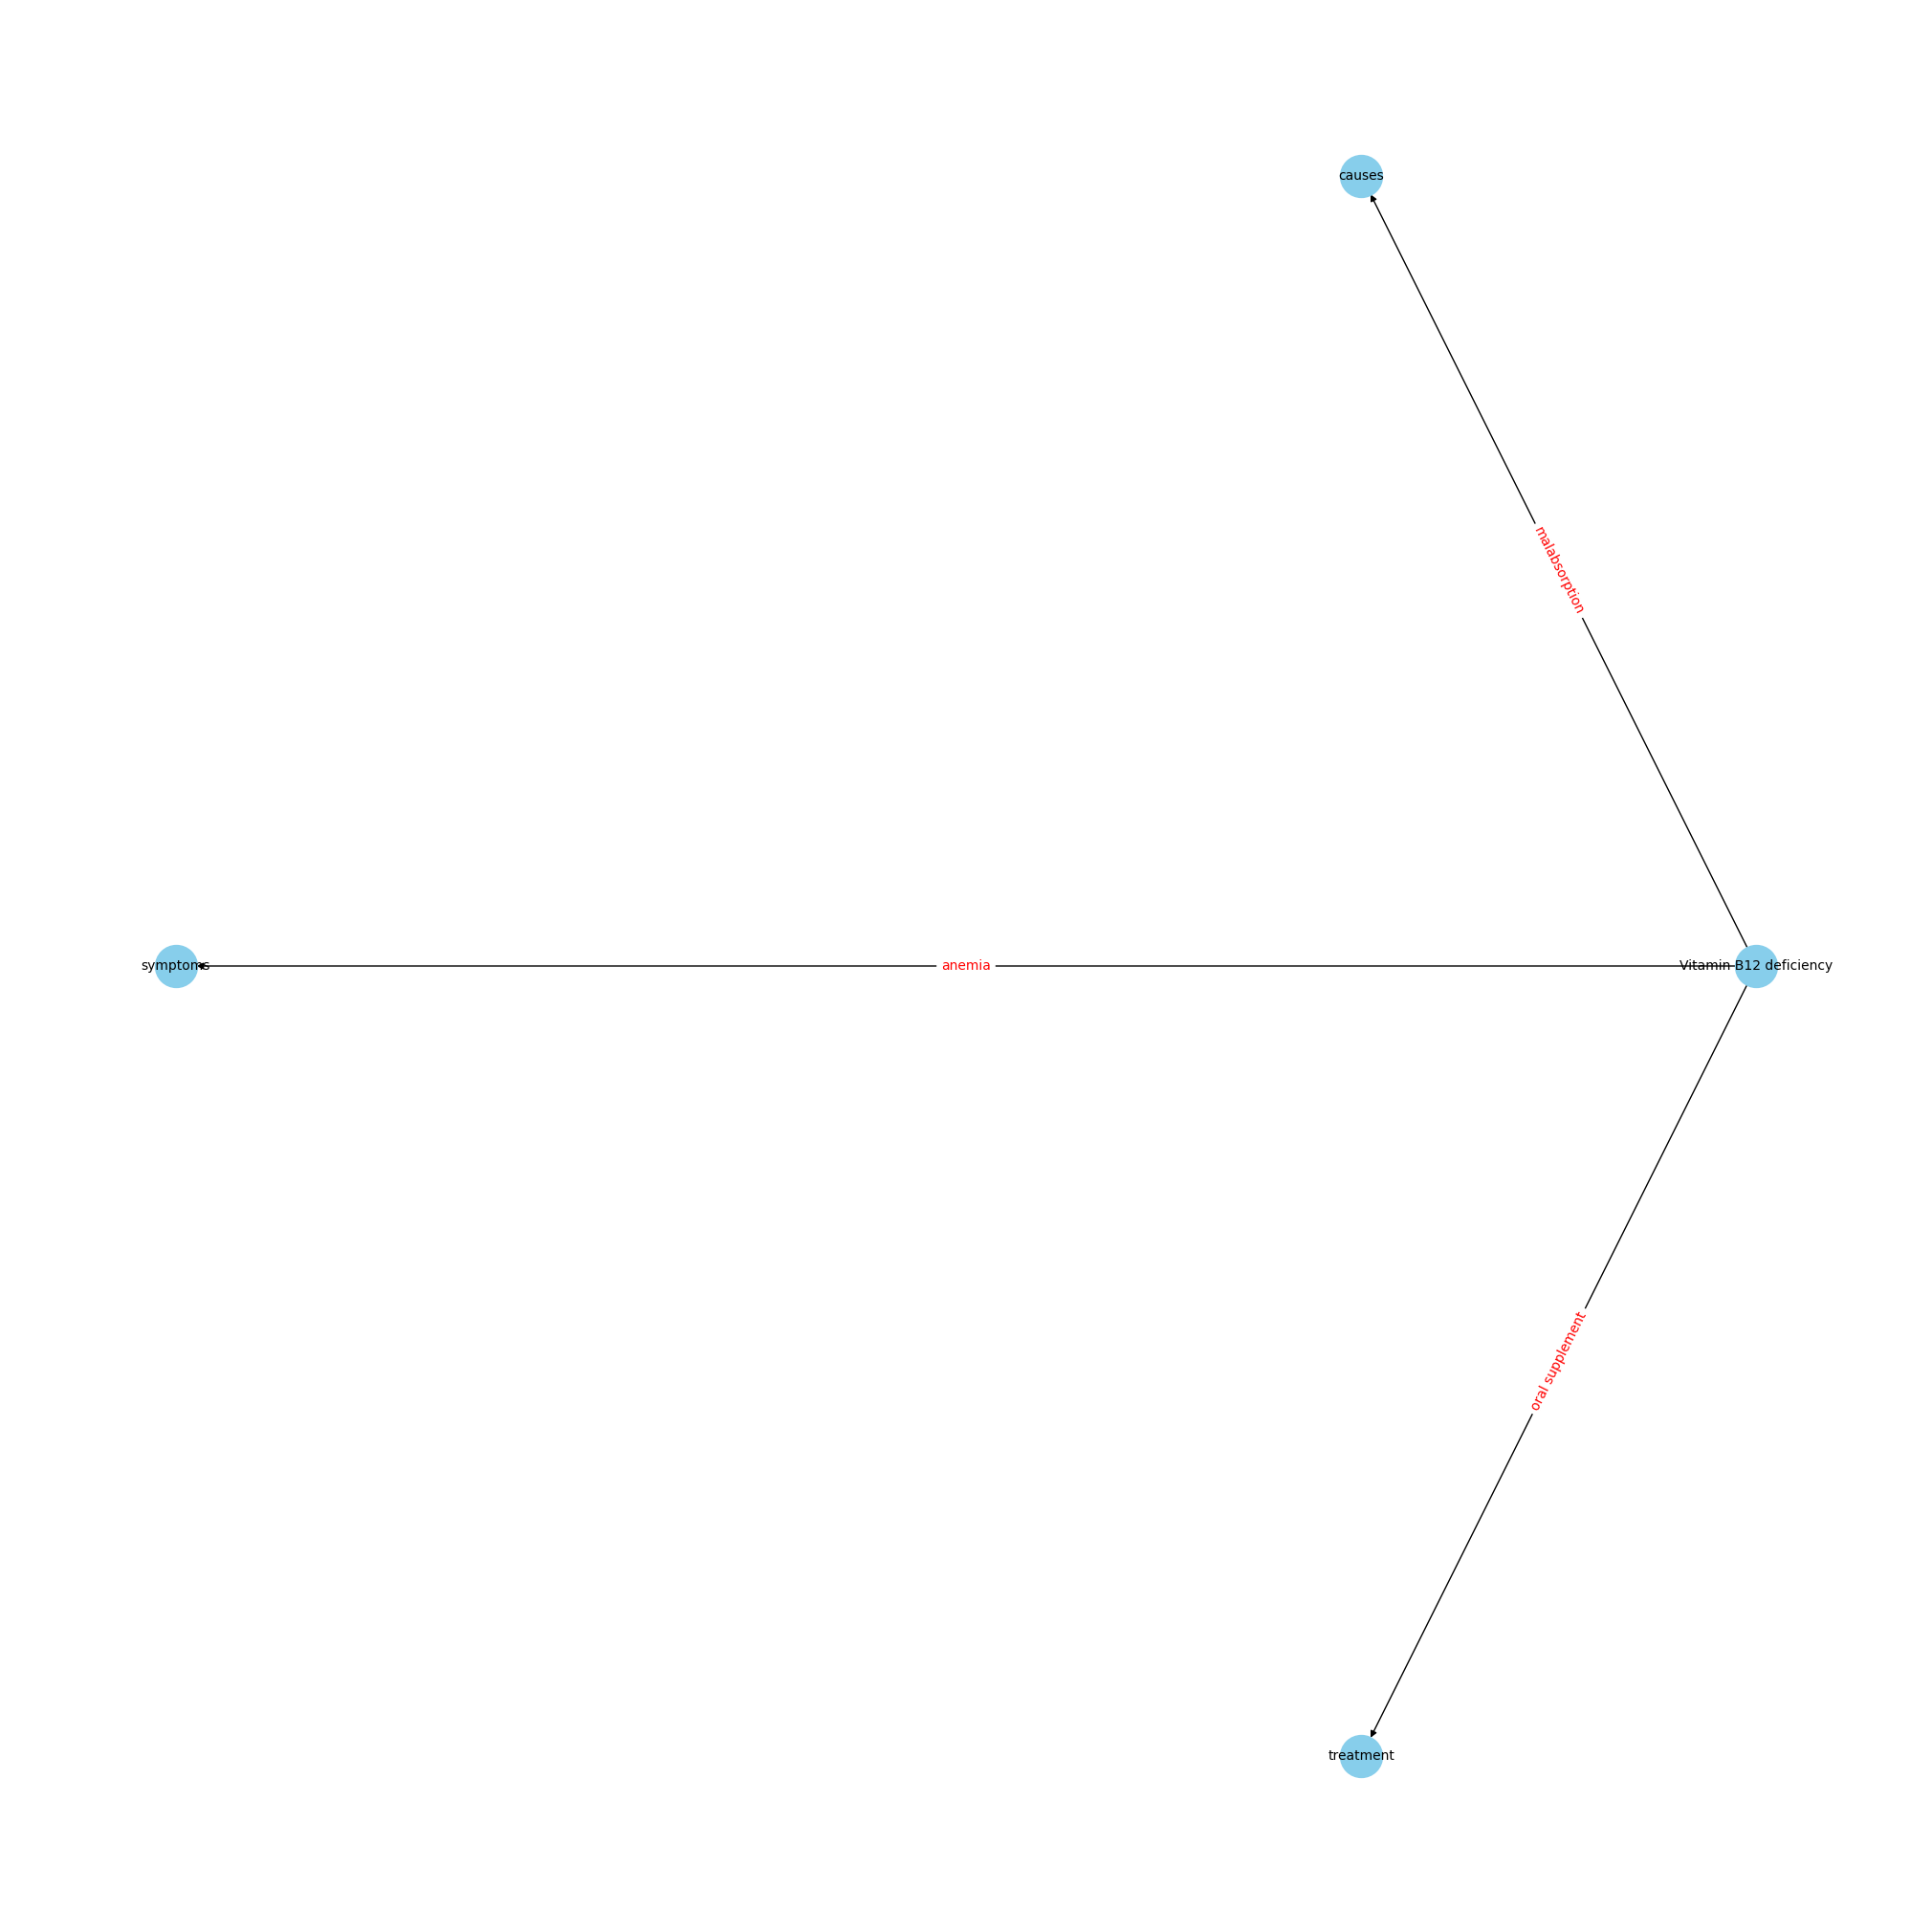

In [27]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add edges and nodes to the graph based on the triples
for subj, pred, obj in triples:
    G.add_edge(subj, obj, label=pred)

# Adjust layout
pos = nx.kamada_kawai_layout(G)

# Draw the graph
plt.figure(figsize=(20, 20))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, arrowsize=10)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Save the graph to a file or display
plt.axis('off')
plt.show()


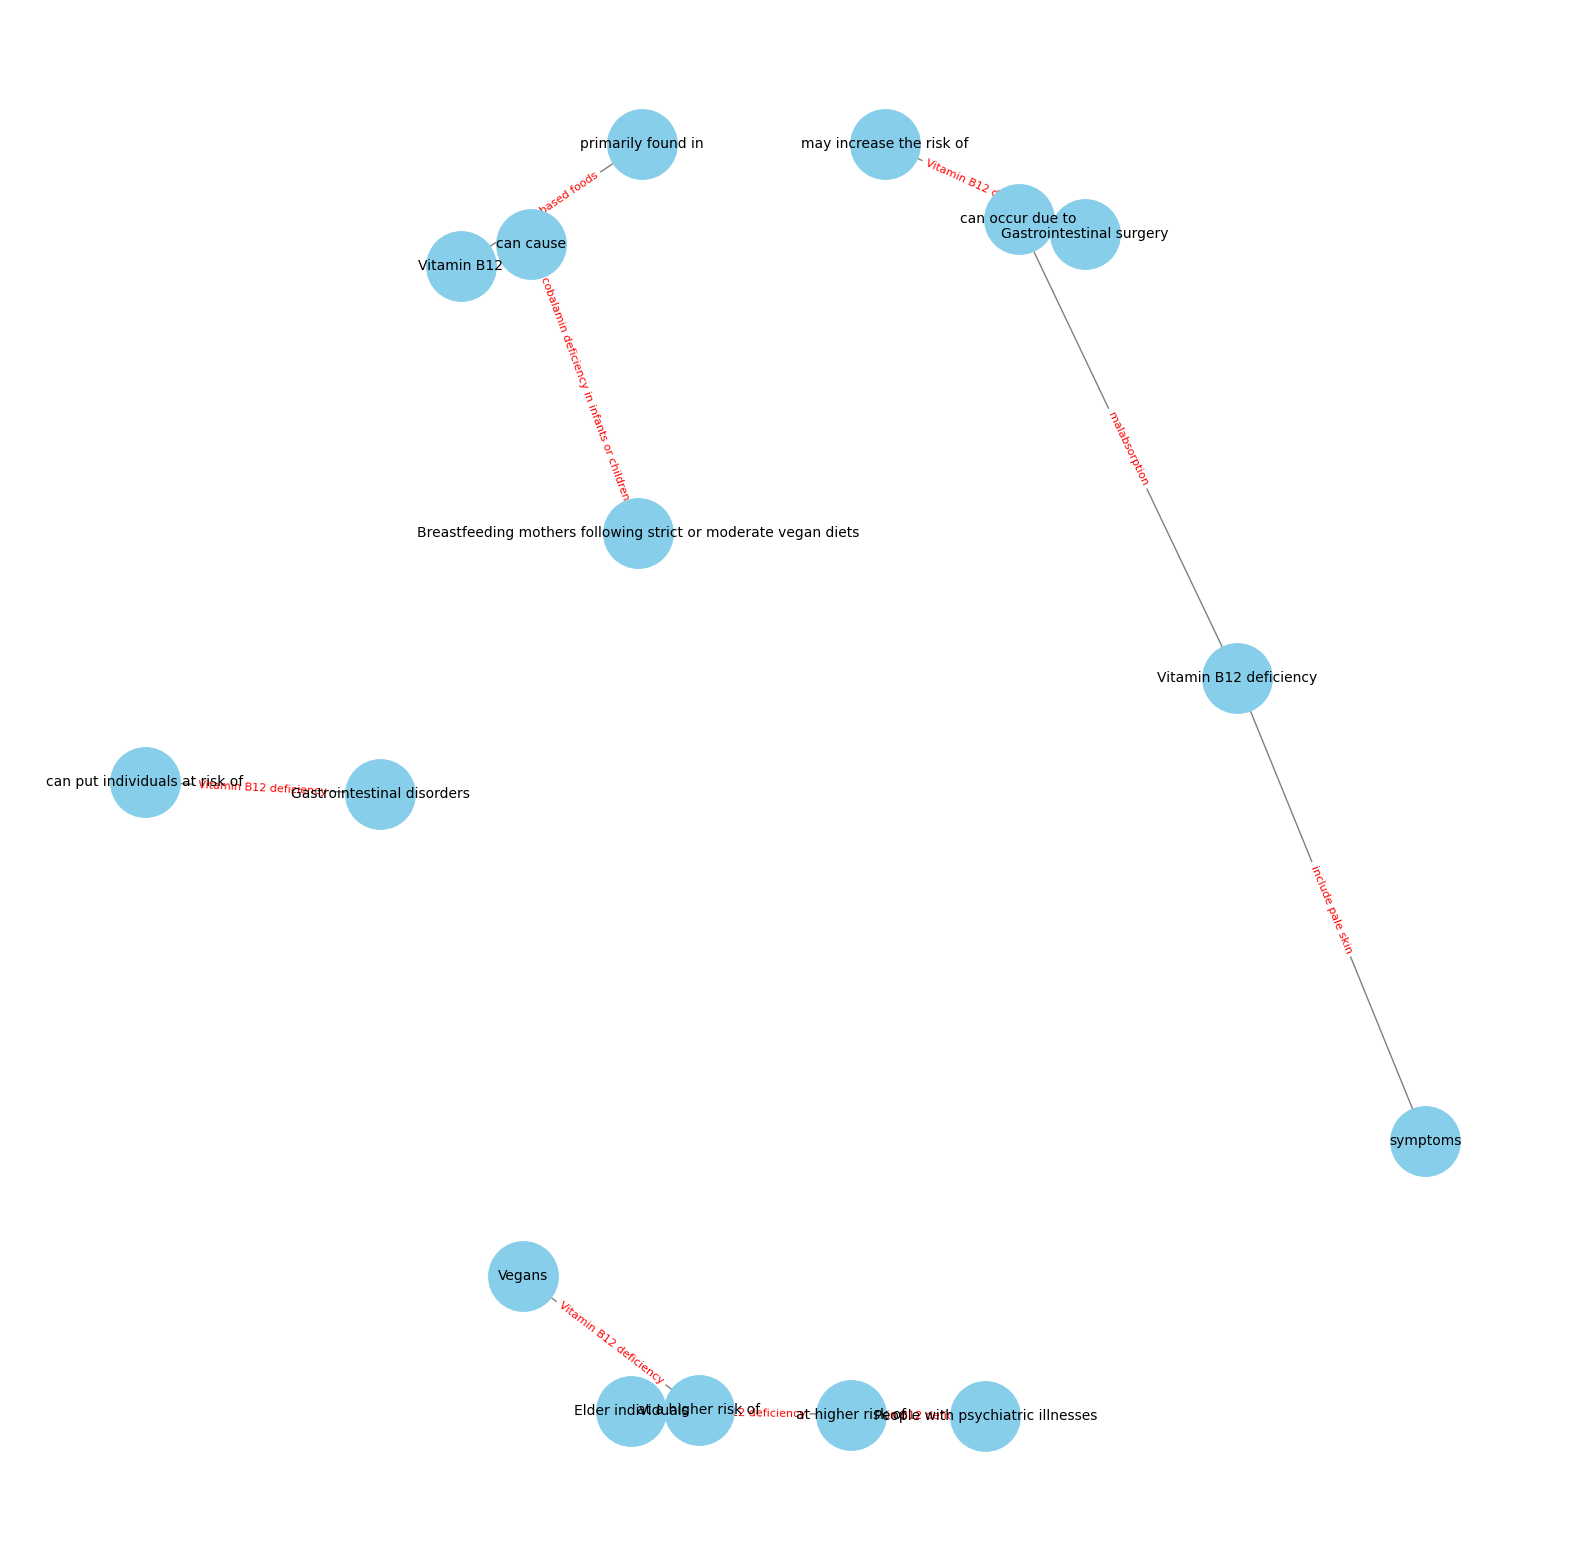

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the list of triples as provided
triples = [
    ('Vitamin B12 deficiency', 'can occur due to', 'inadequate intake'),
    ('Vitamin B12 deficiency', 'can occur due to', 'inborn errors of metabolism or transport'),
    ('Vitamin B12 deficiency', 'can occur due to', 'malabsorption'),
    ('Vitamin B12 deficiency', 'symptoms', 'may include fatigue'),
    ('Vitamin B12 deficiency', 'symptoms', 'include weakness'),
    ('Vitamin B12 deficiency', 'symptoms', 'include shortness of breath'),
    ('Vitamin B12 deficiency', 'symptoms', 'include pale skin'),
    ('Breastfeeding mothers following strict or moderate vegan diets', 'can cause', 'cobalamin deficiency in infants or children'),
    ('Elder individuals', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('People with psychiatric illnesses', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('Vitamin B12', 'primarily found in', 'animal-based foods'),
    ('Gastrointestinal disorders', 'can put individuals at risk of', 'Vitamin B12 deficiency'),
    ('Gastrointestinal surgery', 'may increase the risk of', 'Vitamin B12 deficiency'),
    ('Vegans', 'at a higher risk of', 'Vitamin B12 deficiency')
]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on the triples
for subj, obj, pred in triples:
    G.add_edge(subj, obj, label=pred)

# Generate positions for the nodes using the spring layout algorithm
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the nodes, edges, and labels
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2500)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')

# Extract edge labels from triples and add them to the graph
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Turn off the axes and display the graph
plt.axis('off')
plt.show()



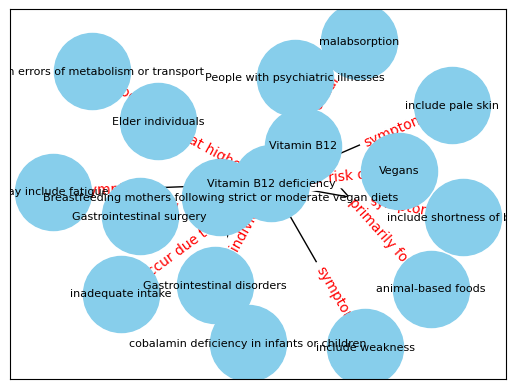

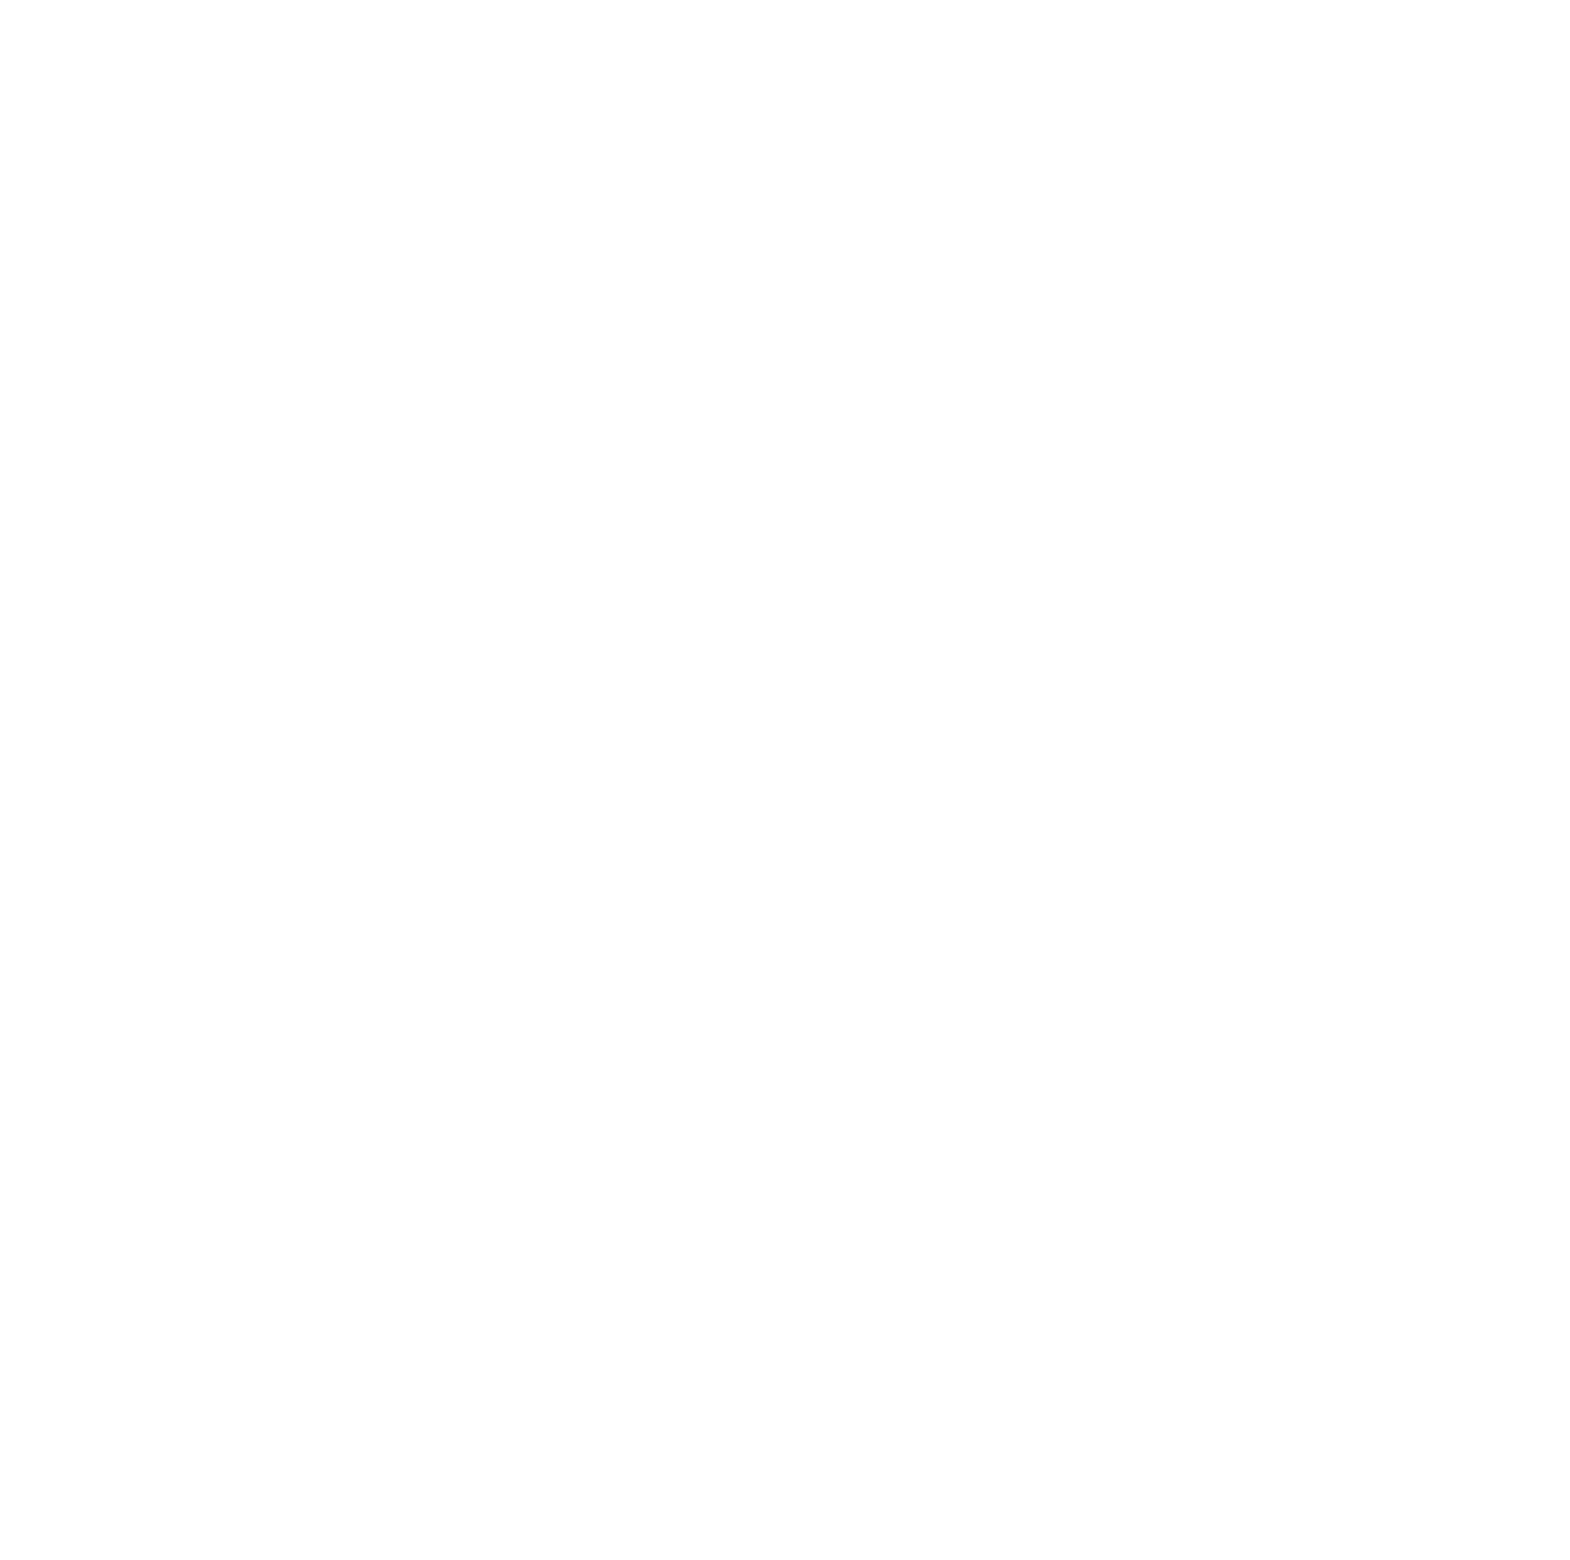

In [29]:
# Let's create a knowledge graph based on the provided triples

import networkx as nx
import matplotlib.pyplot as plt

# Define the list of triples
triples = [
    ('Vitamin B12 deficiency', 'can occur due to', 'inadequate intake'),
    ('Vitamin B12 deficiency', 'can occur due to', 'inborn errors of metabolism or transport'),
    ('Vitamin B12 deficiency', 'can occur due to', 'malabsorption'),
    ('Vitamin B12 deficiency', 'symptoms', 'may include fatigue'),
    ('Vitamin B12 deficiency', 'symptoms', 'include weakness'),
    ('Vitamin B12 deficiency', 'symptoms', 'include shortness of breath'),
    ('Vitamin B12 deficiency', 'symptoms', 'include pale skin'),
    ('Breastfeeding mothers following strict or moderate vegan diets', 'can cause', 'cobalamin deficiency in infants or children'),
    ('Elder individuals', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('People with psychiatric illnesses', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('Vitamin B12', 'primarily found in', 'animal-based foods'),
    ('Gastrointestinal disorders', 'can put individuals at risk of', 'Vitamin B12 deficiency'),
    ('Gastrointestinal surgery', 'may increase the risk of', 'Vitamin B12 deficiency'),
    ('Vegans', 'at a higher risk of', 'Vitamin B12 deficiency')
]

# Create a directed graph
G = nx.DiGraph()

# Add edges and nodes to the graph based on the triples
for subj, pred, obj in triples:
    G.add_node(subj)  # Add the subject as a node
    G.add_node(obj)   # Add the object as a node
    G.add_edge(subj, obj, label=pred)  # Add an edge with a label for the predicate

# Generate a layout for our nodes 
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the graph components
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=3000)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)

# Draw labels for nodes and edges
nx.draw_networkx_labels(G, pos, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.3)

# Set the figure size for better visibility
plt.figure(figsize=(20,20))
plt.axis('off')  # Hide axes for a cleaner look
plt.show()



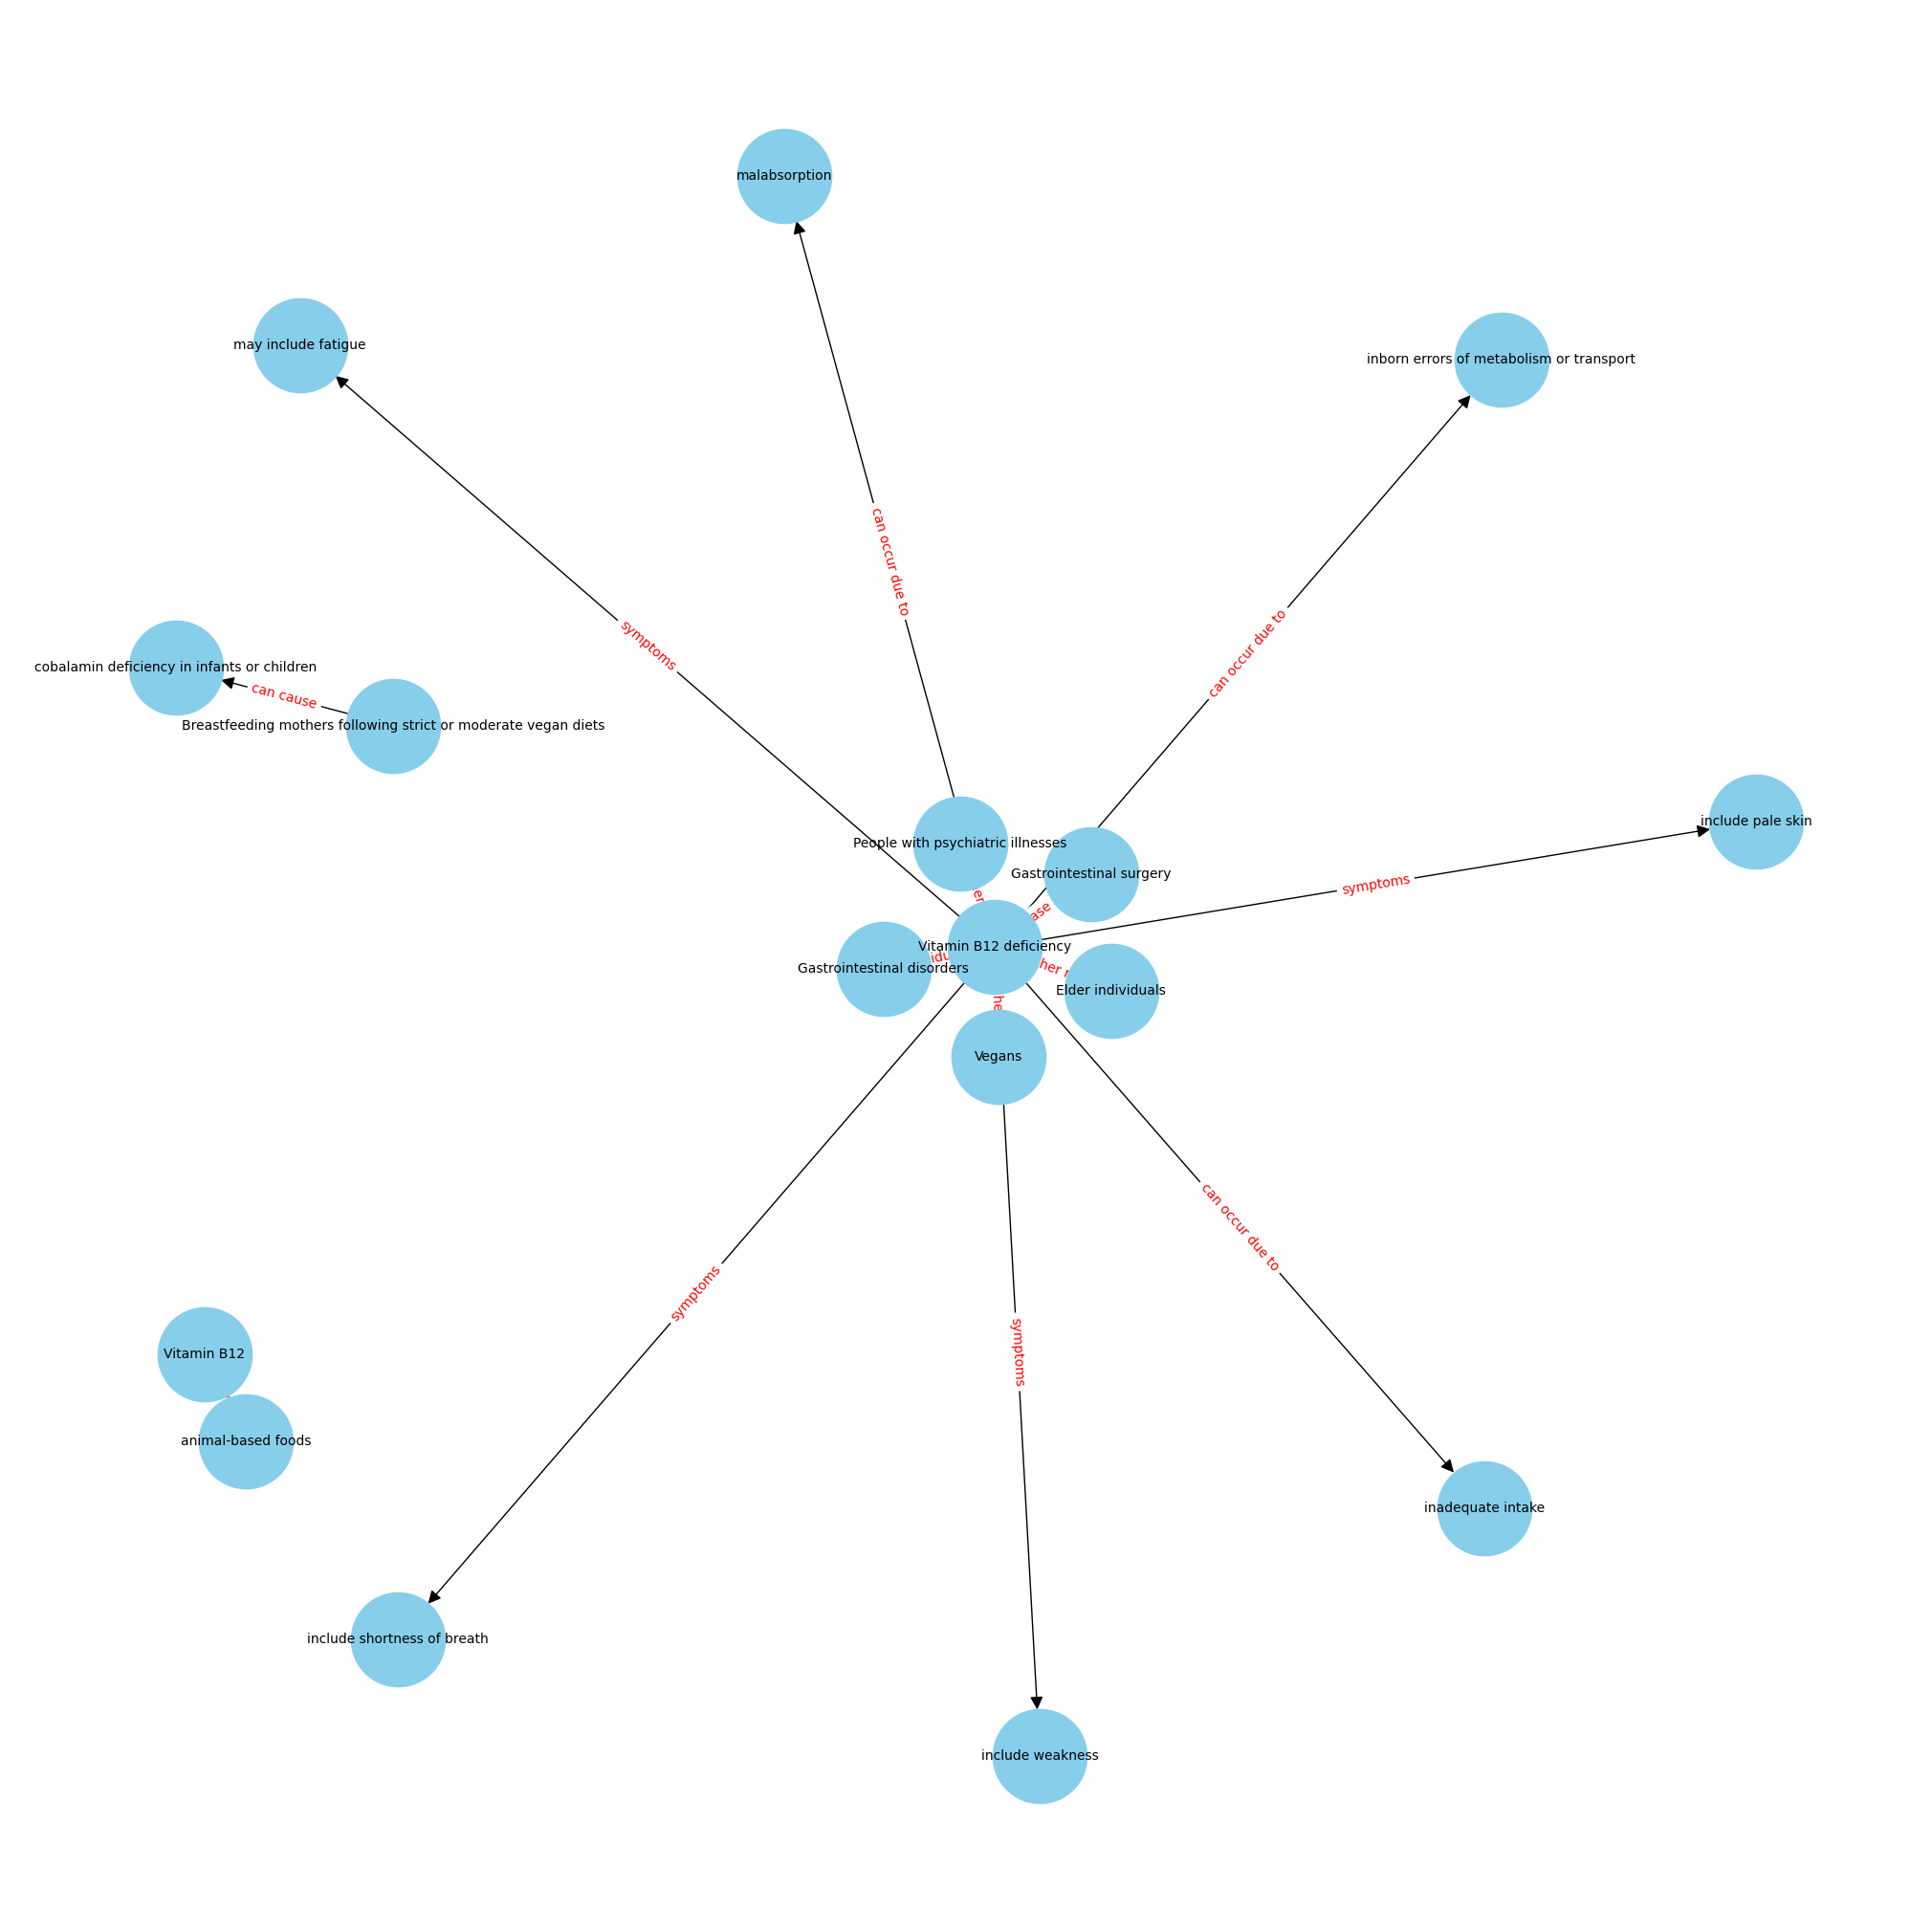

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'triples' contains your data

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph based on the triples
for subj, pred, obj in triples:
    G.add_edge(subj, obj, label=pred)

# Choose a layout that can help minimize overlap
pos = nx.spring_layout(G, k=0.5, iterations=100)

# Draw the graph
plt.figure(figsize=(20, 20))  # Set the size of the plot
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, arrowsize=20)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Remove axes for a cleaner look
plt.axis('off')

# Display the graph
plt.show()

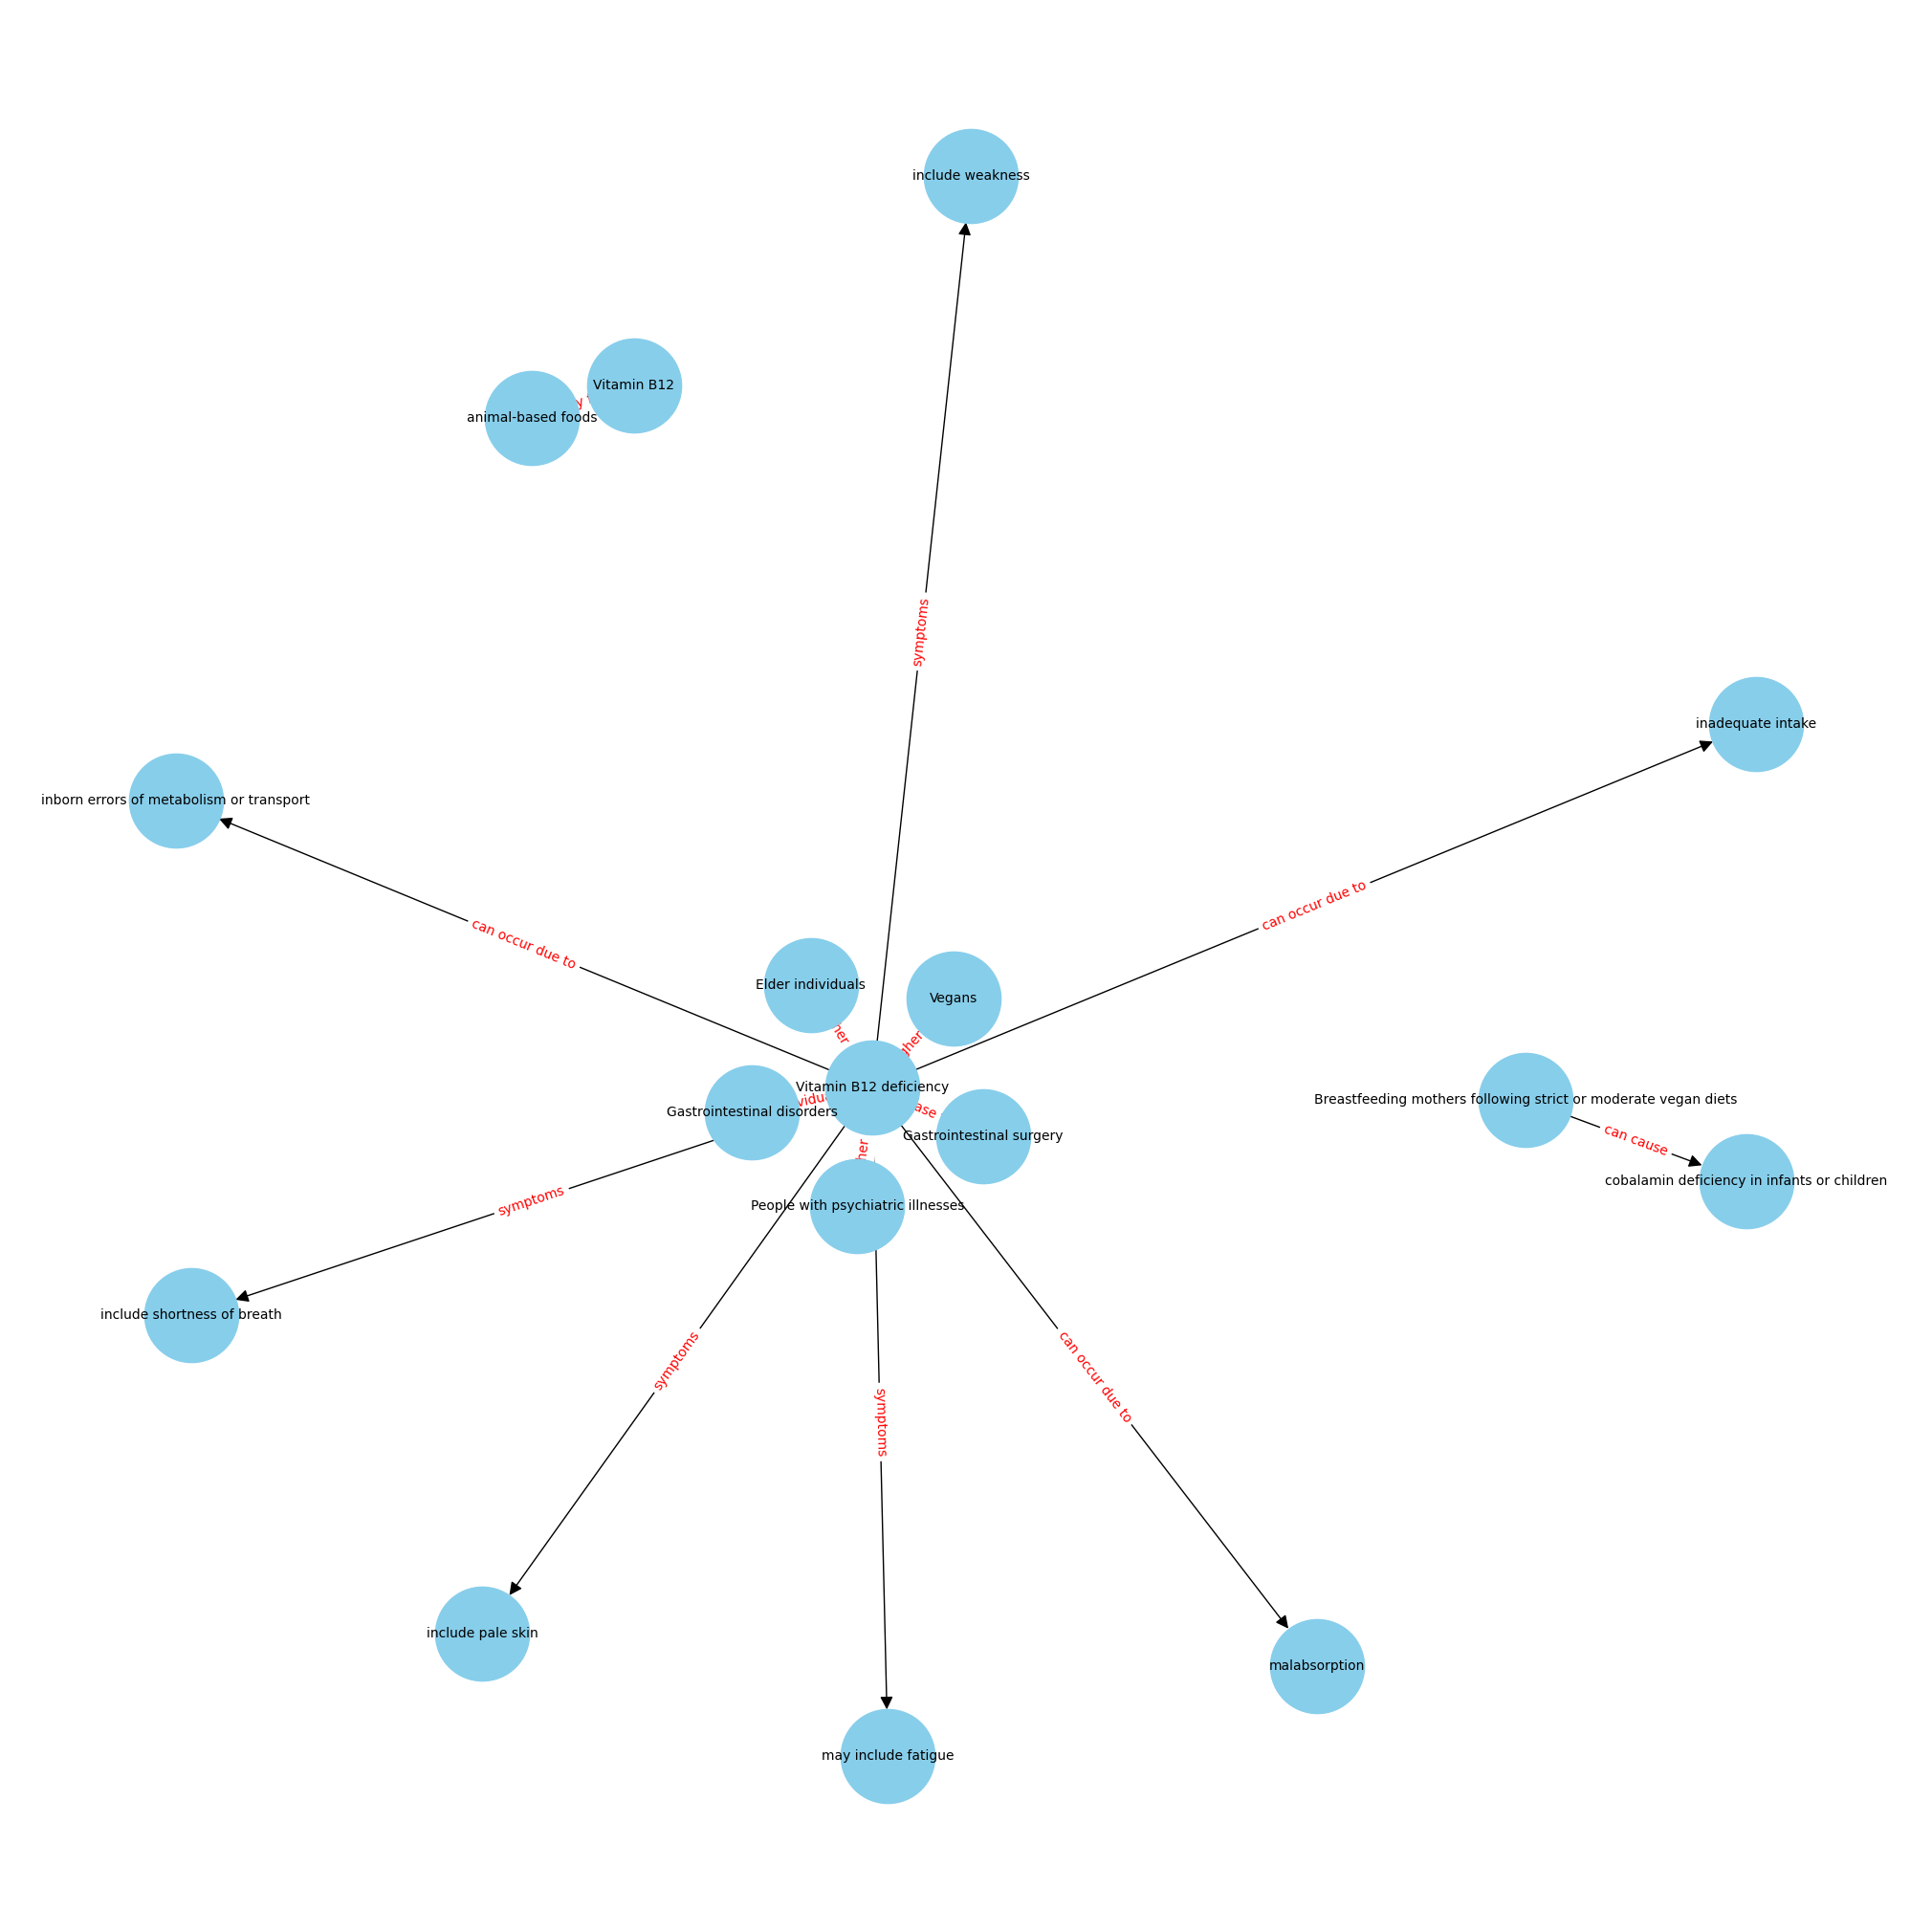

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'triples' contains your data
triples = [
    ('Vitamin B12 deficiency', 'can occur due to', 'inadequate intake'),
    ('Vitamin B12 deficiency', 'can occur due to', 'inborn errors of metabolism or transport'),
    ('Vitamin B12 deficiency', 'can occur due to', 'malabsorption'),
    ('Vitamin B12 deficiency', 'symptoms', 'may include fatigue'),
    ('Vitamin B12 deficiency', 'symptoms', 'include weakness'),
    ('Vitamin B12 deficiency', 'symptoms', 'include shortness of breath'),
    ('Vitamin B12 deficiency', 'symptoms', 'include pale skin'),
    ('Breastfeeding mothers following strict or moderate vegan diets', 'can cause', 'cobalamin deficiency in infants or children'),
    ('Elder individuals', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('People with psychiatric illnesses', 'at higher risk of', 'Vitamin B12 deficiency'),
    ('Vitamin B12', 'primarily found in', 'animal-based foods'),
    ('Gastrointestinal disorders', 'can put individuals at risk of', 'Vitamin B12 deficiency'),
    ('Gastrointestinal surgery', 'may increase the risk of', 'Vitamin B12 deficiency'),
    ('Vegans', 'at a higher risk of', 'Vitamin B12 deficiency')
]
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph based on the triples
for subj, pred, obj in triples:
    G.add_edge(subj, obj, label=pred)

# Choose a layout that can help minimize overlap
pos = nx.spring_layout(G, k=0.5, iterations=100)

# Draw the graph
plt.figure(figsize=(20, 20))  # Set the size of the plot
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, arrowsize=20)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Remove axes for a cleaner look
plt.axis('off')

# Display the graph
plt.show()

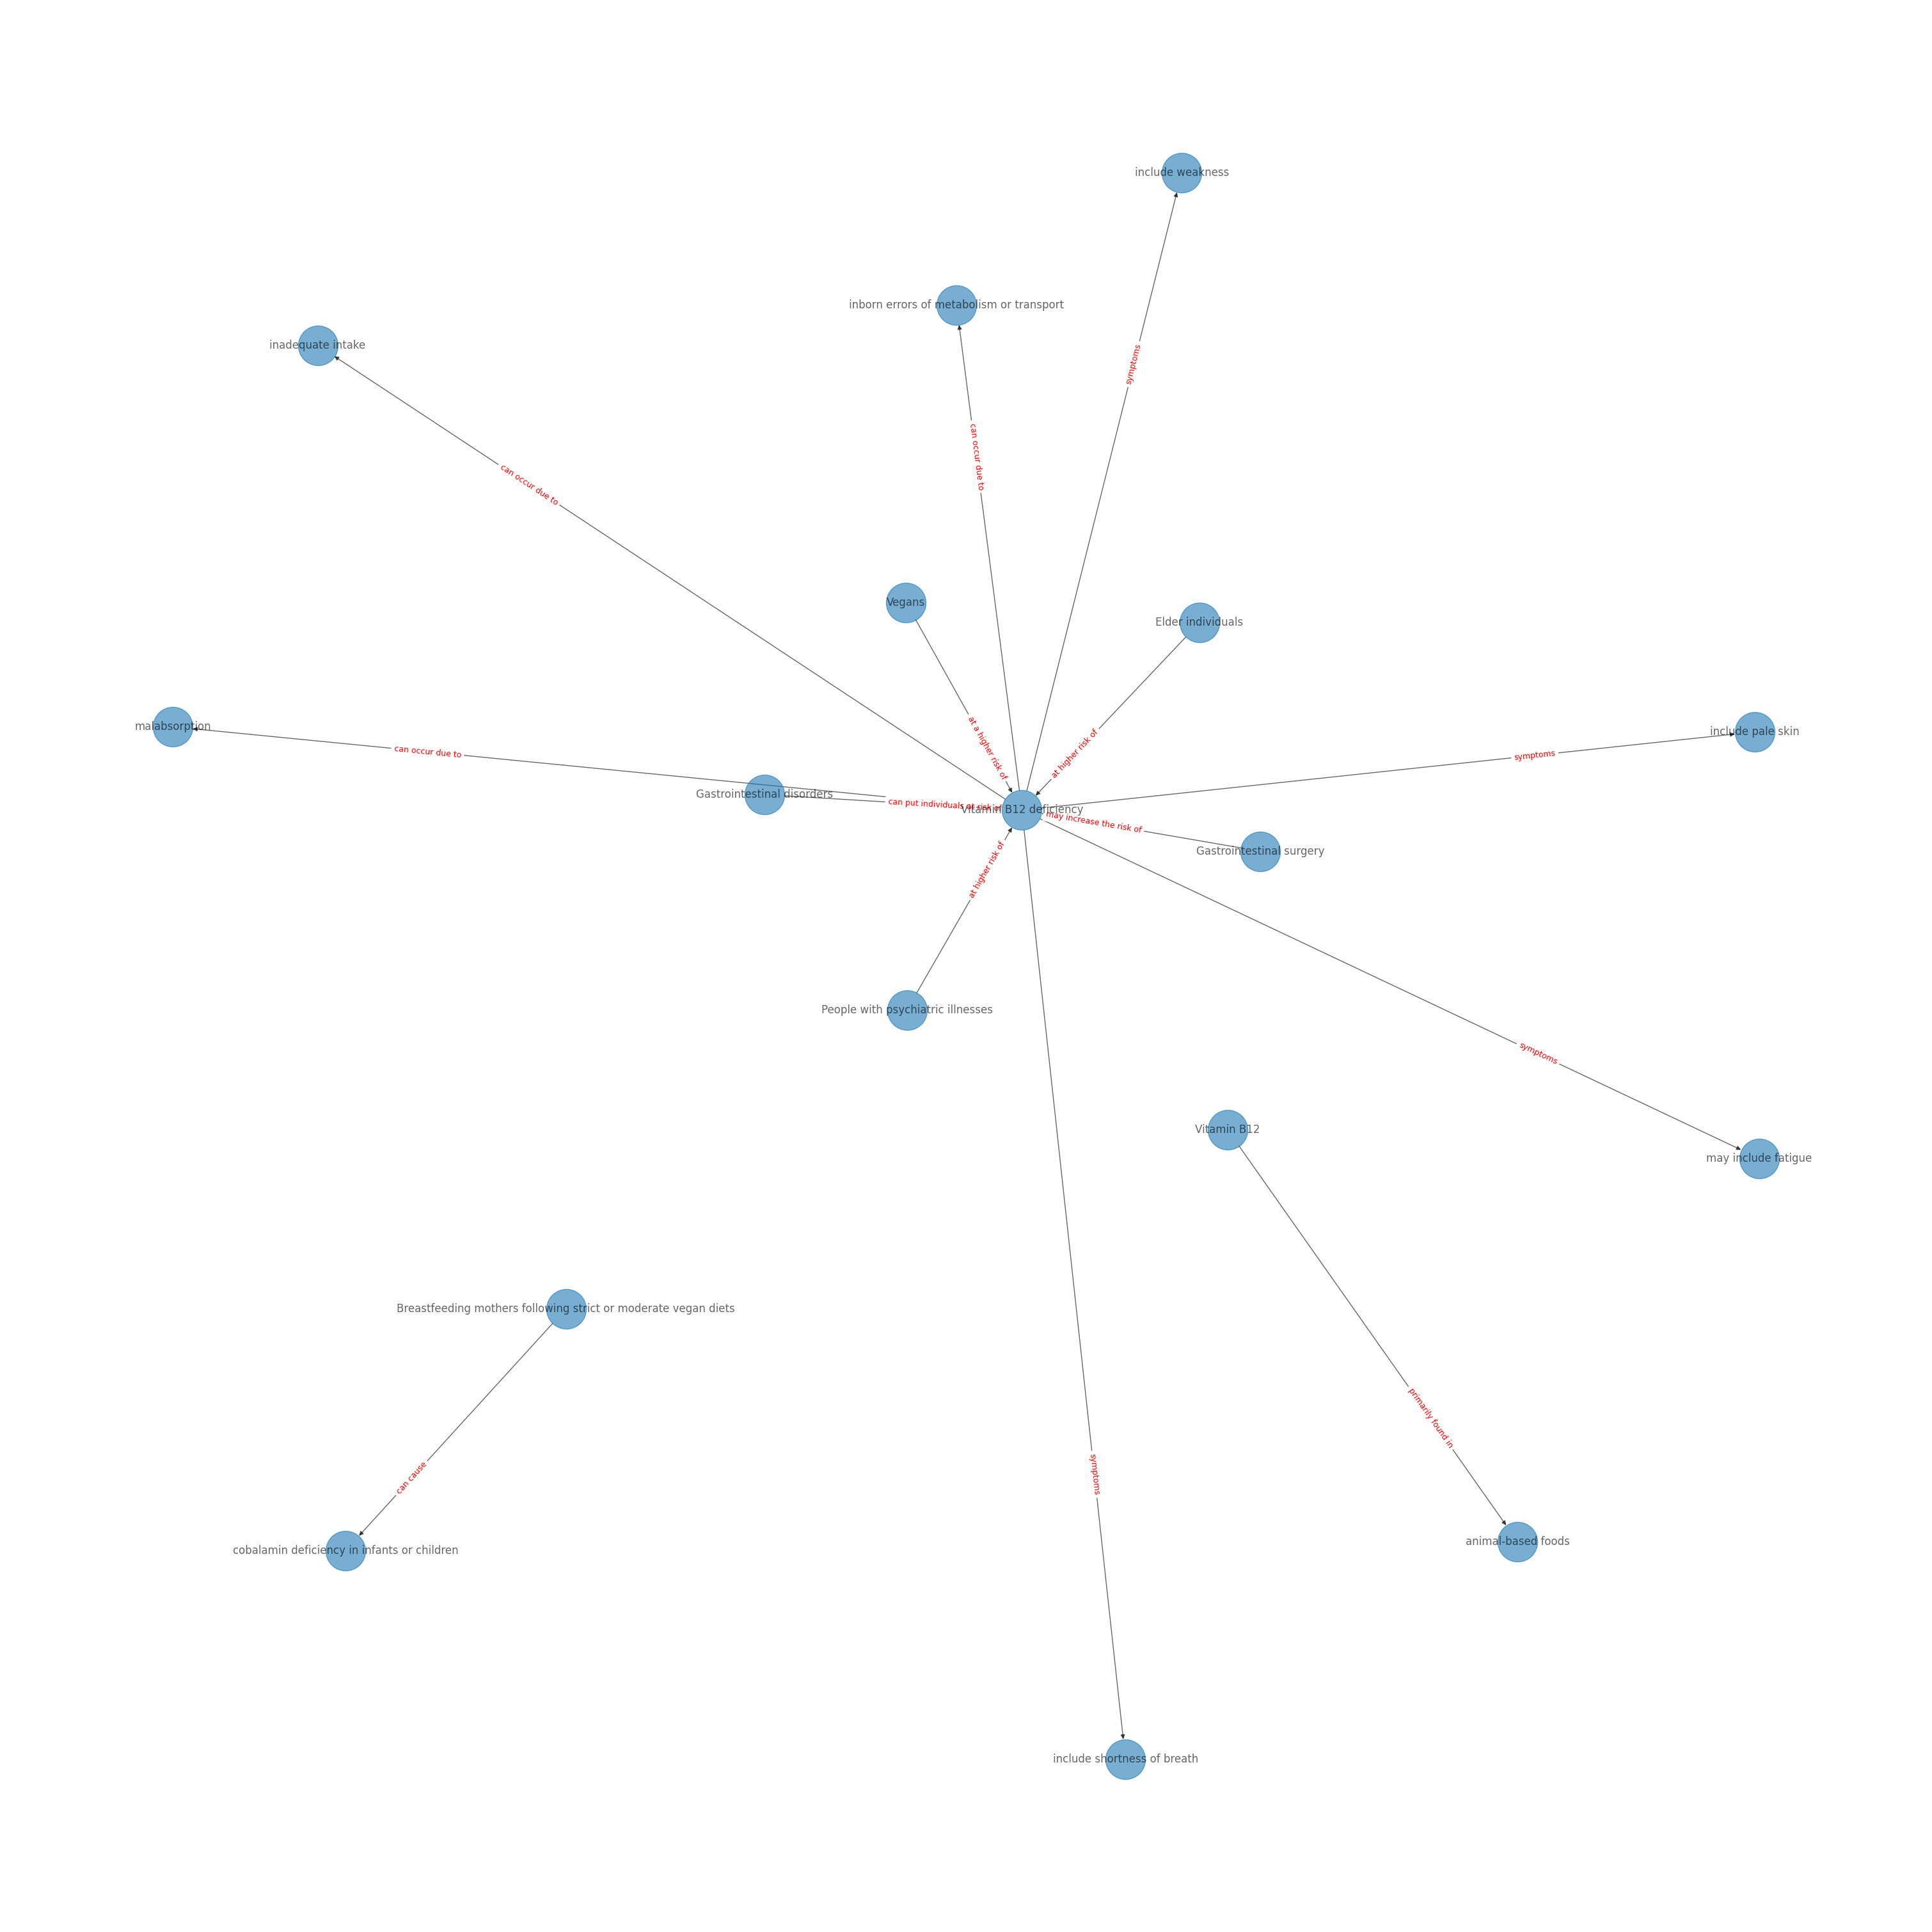

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the triples here
# ...

# Create the directed graph from the triples
G = nx.DiGraph()
for s, p, o in triples:
    G.add_node(s)  # Add the subject node
    G.add_node(o)  # Add the object node
    G.add_edge(s, o, label=p)  # Add the edge with the predicate as the label

# Adjust the layout to spread out the nodes more
pos = nx.spring_layout(G, k=1.0, iterations=100)  # Increase 'k' for more space

# Increase the figure size for better visibility
plt.figure(figsize=(30, 30))

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_size=2000, alpha=0.6, arrows=True)

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.3, font_size=9)

# Hide the axes for a cleaner look
plt.axis('off')
plt.show()


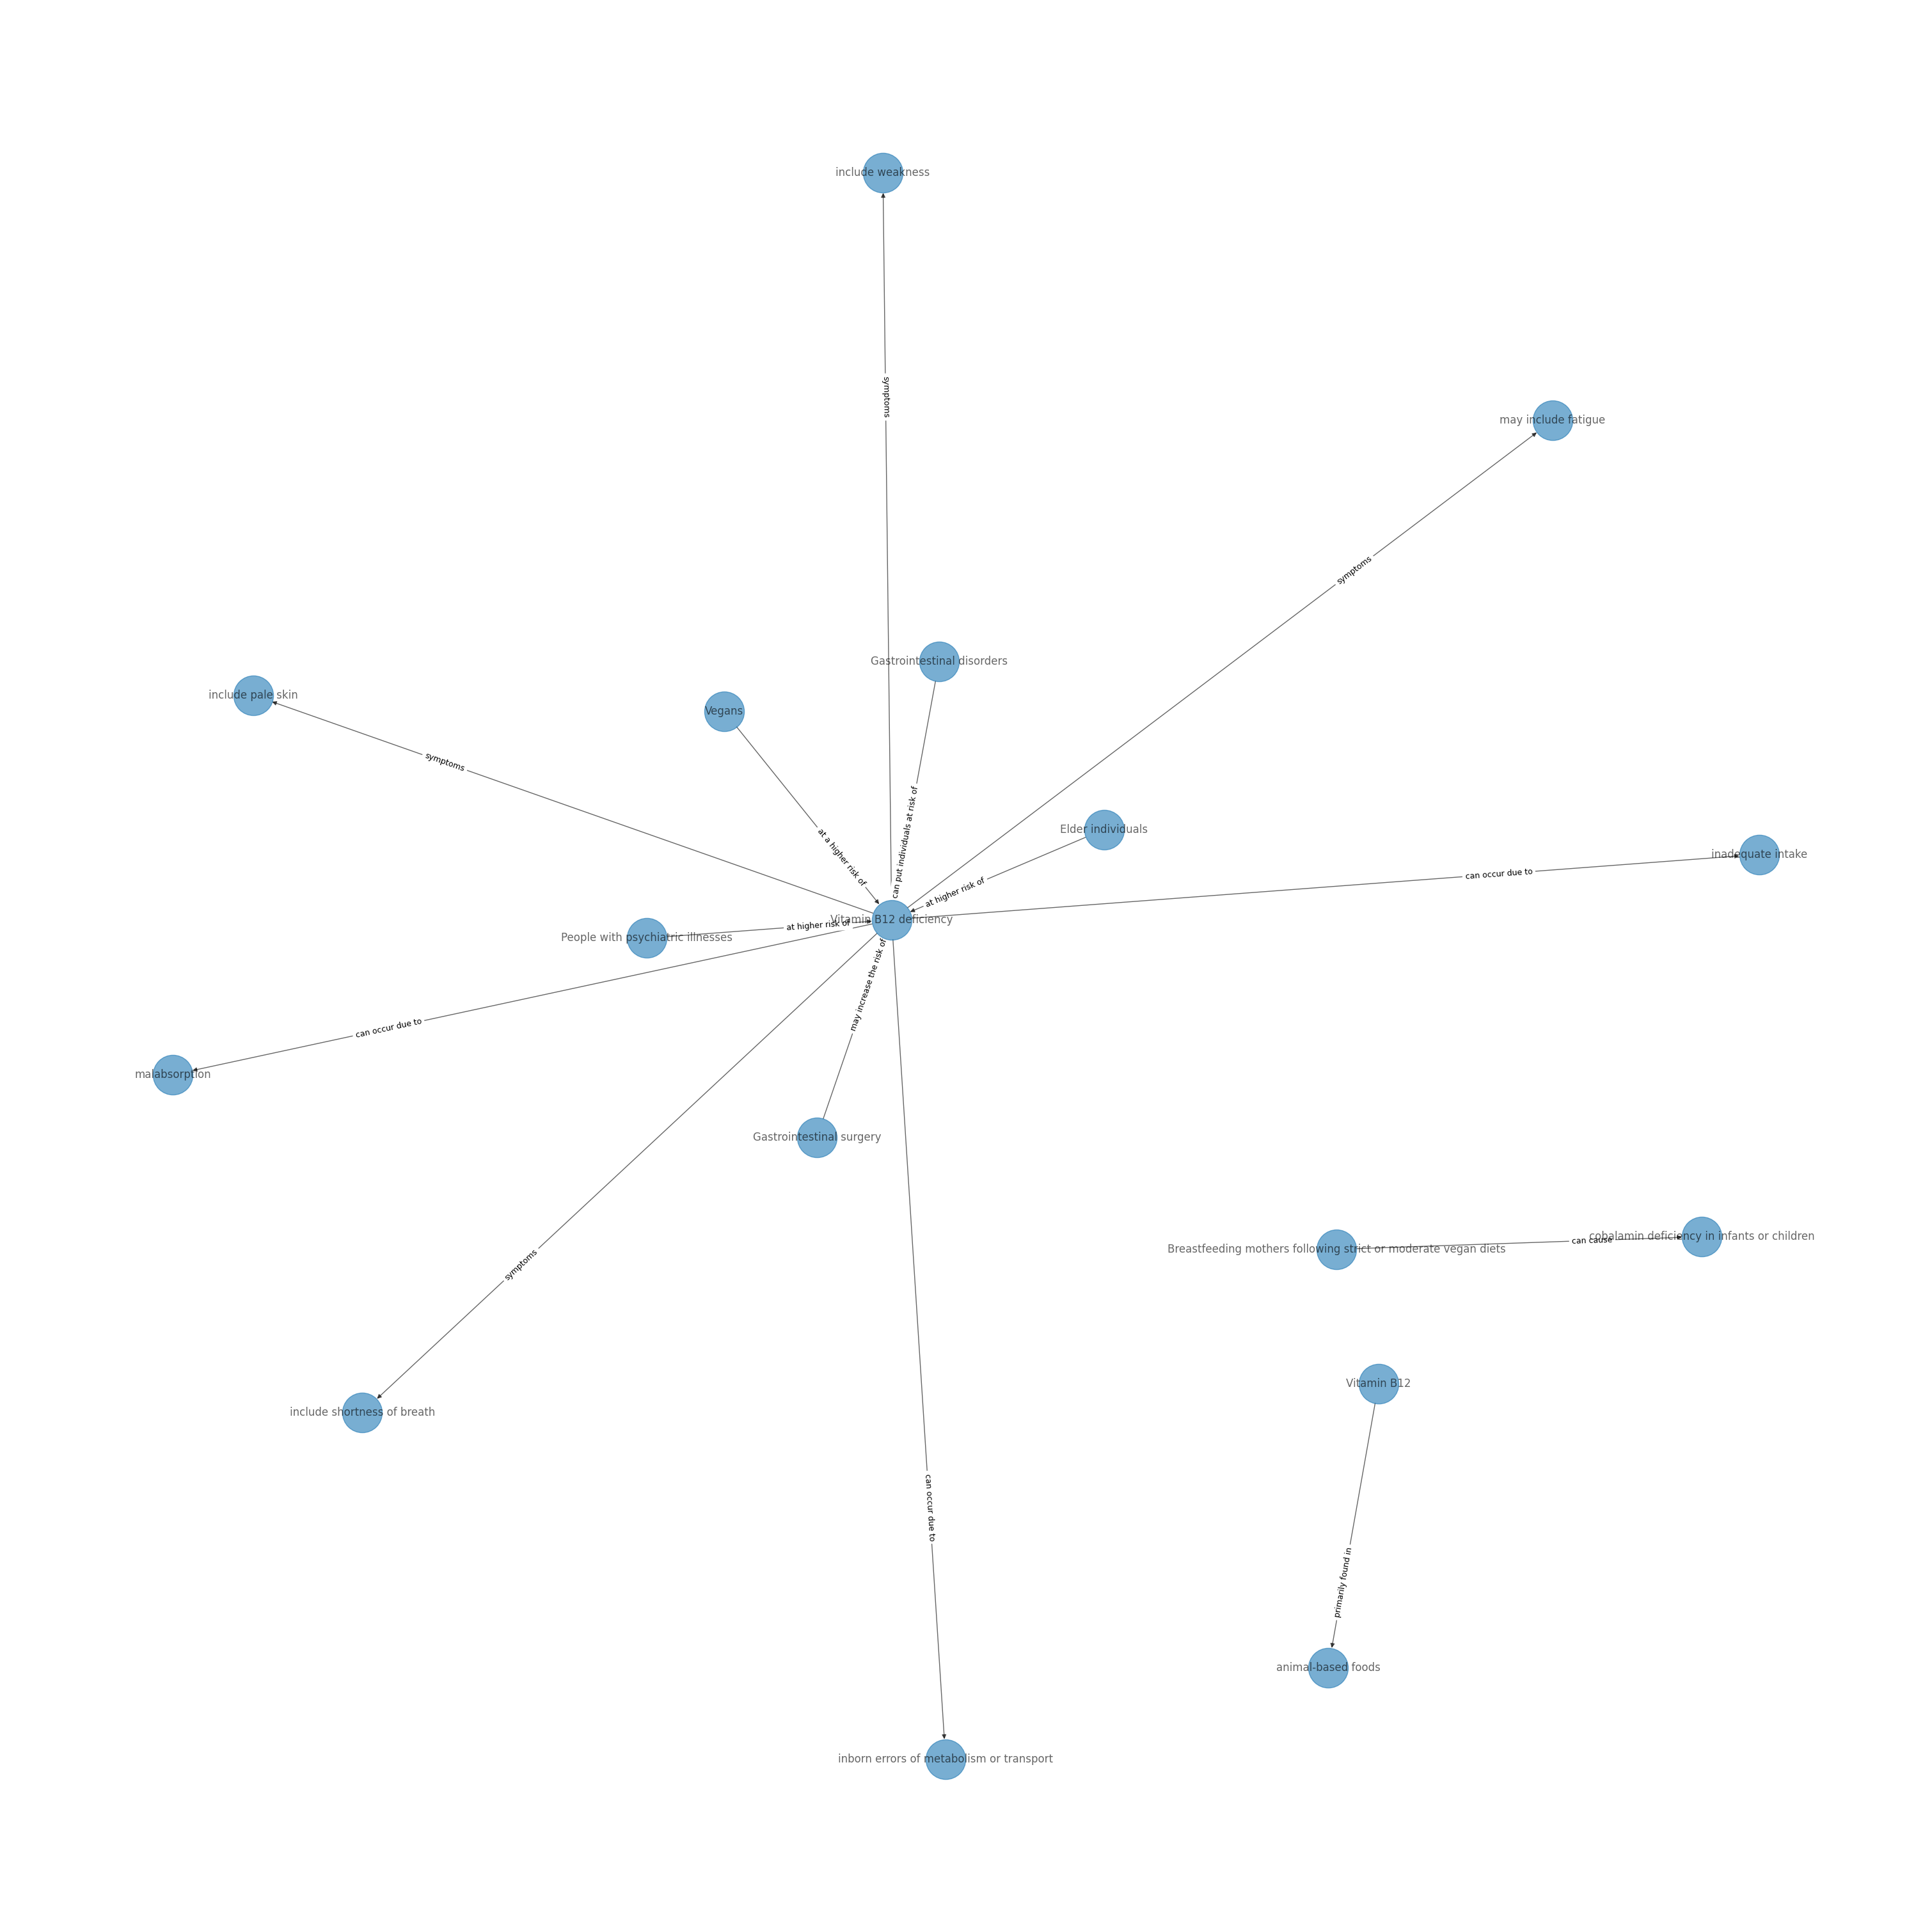

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the triples here
# ...

# Create the directed graph from the triples
G = nx.DiGraph()
for s, p, o in triples:
    G.add_node(s)  # Add the subject node
    G.add_node(o)  # Add the object node
    G.add_edge(s, o, label=p)  # Add the edge with the predicate as the label

# Adjust the layout to spread out the nodes more
pos = nx.spring_layout(G, k=1.0, iterations=100)  # Increase 'k' for more space

# Increase the figure size for better visibility
plt.figure(figsize=(30, 30))

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_size=2000, alpha=0.6, arrows=True)

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=9)

# Hide the axes for a cleaner look
plt.axis('off')
plt.show()


In [34]:
contexts

[Document(page_content='infants or children without any predisposing factors. In \nearly stages, cobalamin deficiency is secondary to the \nmaternal deficiency among breast-feeding mothers fol-\nlowing strict or moderate vegan diets. The main causes \nof vitamin B12 deficiency mostly are inadequate intake, \ninborn errors of metabolism or transport, and malabsorp-\ntion. Elder individuals, people with psychiatric illnesses,', metadata={'page': 2, 'source': 'data\\vitamindeficiencies.pdf'}),
 Document(page_content='and supplements: where do Americans get their nutrients? J \nNutr 2011;141:1847-54. https://doi.org/10.3945/jn.111.142257\n[79] Kantor ED, Rehm CD, Du M, White E, Giovannucci EL. \nTrends in dietary supplement use among US adults from \n1999-2012. JAMA 2016;316:1464-74. https://doi.org/10.1001/\njama.2016.14403\n[80] Gahche JJ, Bailey RL, Potischman N, Dwyer TJ. Dietary \nsupplement use was very high among older adults in the United \nStates in 2011–2014. J Nutr 2017;147:1968

In [39]:
query = "What are all the symptoms, cures and causes of Vitamin D deficiency?"
contexts_new = retriever.get_relevant_documents(query)

In [40]:
human_template = generate_human_message(query, contexts_new)
template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant. Provide an in-detailed answer to the users' question using the provided contexts."),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({}) 

'Symptoms of Vitamin D deficiency include hypocalcemia and hypophosphatemia, which can lead to osteomalacia in adults and rickets in children. Additionally, Vitamin D deficiency is associated with immunomodulatory disorders, cardiovascular diseases, hypertension, and insulin resistance in adults.\n\nCauses of Vitamin D deficiency can vary and depend on various dietary and environmental factors. These factors include reduced dietary intake, decreased synthesis, and malabsorption of Vitamin D. Factors such as body mass index, sun exposure, and milk ingestion can also contribute to Vitamin D deficiency.\n\nCures for Vitamin D deficiency primarily involve Vitamin D supplementation and implementing a diet rich in Vitamin D and calcium. For most people over the age of one, supplementing with 50,000 IU of ergocalciferol for at least eight weeks is considered sufficient. In some countries, cow milk, infant formulas, and different cereals are also supplemented with Vitamin D to help prevent def

In [30]:
graph.write_to_gml("graph.gml")

In [31]:
from langchain.indexes.graph import NetworkxEntityGraph
loaded_graph = NetworkxEntityGraph.from_gml("graph.gml") 
loaded_graph.get_triples()

[]

In [119]:
from langchain.llms import OpenAI 
from langchain.indexes import GraphIndexCreator 
from langchain.chains import GraphQAChain 
from langchain.document_loaders import TextLoader

index_creator = GraphIndexCreator(llm=OpenAI(temperature = 0)) 
graph = index_creator.from_text(context) 
triples = graph.get_triples()

In [7]:
! pip install networkx

In [28]:
import networkx as nx 
import matplotlib.pyplot as plt

# Read the graph from the file
G = nx.read_gml("graph.gml")

# Draw the graph
nx.draw(G, with_labels = True)

# Show the graph
plt.show()

NetworkXError: input contains no graph

In [134]:
query = "What are the symptoms, causes, and cures of Vitamin B12 deficiency?"
contexts = retriever.get_relevant_documents(query)

human_template = generate_human_message(query, contexts)
template = ChatPromptTemplate.from_messages([
    ("system", "You are a networked intelligence helping a human track knowledge triples. Extract all of the knowledge triples, A knowledge triple is a clause that contains a subject, a predicate, and an object. The subject is the entity being described, the predicate is the property of the subject that is being described, and the object is the value of the property. Provide triples as an answer to the users' question using the provided contexts."),
    ("human", human_template)
])

llm = ChatOpenAI()
chain = LLMChain(prompt=template, llm=llm)
chain.run({}) 

'Knowledge triples:\n1. Vitamin B12 deficiency - symptoms - inadequate intake, inborn errors of metabolism or transport, malabsorption\n2. Vitamin B12 deficiency - causes - inadequate intake, inborn errors of metabolism or transport, malabsorption\n3. Vitamin B12 deficiency - cures - increase intake of Vitamin B12 through diet or supplements, address underlying causes of malabsorption or inborn errors of metabolism or transport.'

In [137]:
new_context = '''\n1. Vitamin B12 deficiency - symptoms - inadequate intake, inborn errors of metabolism or transport, malabsorption\n2. Vitamin B12 deficiency - causes - inadequate intake, inborn errors of metabolism or transport, malabsorption\n3. Vitamin B12 deficiency - cures - increase intake of Vitamin B12 through diet or supplements, address underlying causes of malabsorption or inborn errors of metabolism or transport'''

In [139]:
index_creator = GraphIndexCreator(llm=OpenAI(temperature = 0)) 
graph = index_creator.from_text(new_context) 
new_triples = graph.get_triples()

In [140]:
new_triples

[('Vitamin B12 deficiency', 'inadequate intake', 'has causes of'),
 ('Vitamin B12 deficiency',
  'inborn errors of metabolism or transport',
  'has causes of'),
 ('Vitamin B12 deficiency', 'malabsorption', 'has causes of'),
 ('Vitamin B12 deficiency',
  'increase intake of Vitamin B12 through diet or supplements',
  'has cures of'),
 ('Vitamin B12 deficiency',
  'address underlying causes of malabsorption or inborn errors of metabolism or transport)\nEND OF EXAMPL',
  'has cures of')]